#  Predicting Stock Yields using NLP

Deep learning NLP techniques to map raw text to dense vector representations have had some surprising success in the world of computer natural language processing compared to classical means of encoding text. In this notebook we will attempt to leverage some of these techniques to help assist us in time series analysis on stock yields. We will be analyzing data from four different companies: Wells Fargo, JPMorgan Chase, Bank of America, and Citigroup, and the text data we will be leveraging are the SEC forms 8-K forms of these four banks. The 8-K form was chosen because it tends to be the more text rich SEC document when compared to others.

## Fetching Data

For this project we will need two data sources. Firstly we will need access to each stocks's historical price data. We will use an API to access this data. This gives us two options: Quandl's end of day stock price data API, or Alphavantage's end of day stock price, adjusted time series API. Since Quandl's API costs money we will use Alphavantage's API since its free. The second data source we need is access to each stock's published 8-K forms. For this data source we will web scrape the SEC's database: EDGAR, to gather the necessary data.

In [5]:
# Importing Libraries
import os
import io
import sys
import re
import lxml
import json
import requests
import numpy as np
import pandas as pd

from datetime import date
from functools import reduce
from bs4 import BeautifulSoup

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
# Company Stock Ticker and CIK number
ticker = 'WFC'
competitors = ['JPM', 'BAC', 'C']
tickers = [ticker] + competitors
# Random Seed
seed = 42

### Fetching Stock Price Data

Fetching end of day stock price data from alphavantage: https://www.alphavantage.co/ using fetch_stock_data. Then checking the returned DataFrame object to confirm that the end of day stock price data was successfully loaded into the object.

In [3]:
# Defining Functions and Classes

def get_api_key(source):
    '''
    STILL NEEDS WORK, want to keep same API, but don't know how to link to area where user api keys are stored.
    
    Returns api key for the specific source, :param source:.
    
    :param source: string, name of api source
    
    ---> String, api key for the the specific source :param source:
    '''
    
    path_to_keys = os.path.join(project_dir, 'api_keys.json')
    with open(path_to_keys, 'r') as f:
        api_keys = json.load(f)
    
    return api_keys[source]


def fetch_stock_data(ticker, start_date, end_date=None, source='alphavantage'):
    '''
    Returns end of day stock price DataFrame from various sources.
    
    :param ticker: string, stock ticker
    :param start_date: string, date to start collecting data after, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    :param source: string 'alphavantage' or 'quandl', specifies the source of the data
    
    ---> DataFrame, of end of day stock price data
    '''
    
    # endpoints for each data source
    source_urls = {'alphavantage': 'https://www.alphavantage.co/query',
                   'quandl': 'https://www.quandl.com/api/v3/datasets/EOD/'}
    
    # API parameters for each data source
    source_params = {'alphavantage': {'function': 'TIME_SERIES_DAILY_ADJUSTED',
                                      'symbol': ticker, 'datatype': 'csv', 'apikey': get_api_key(source),
                                      'outputsize': 'full'},
                     'quandl': {'api_key': get_api_key(source)}}

    # Setting endpoints
    url = source_urls[source]
    if source == 'quandl':
        url = url + ticker + '.csv'
    
    # Settings API parameters
    params = source_params[source]
    
    # Requesting API
    response = requests.get(url, params=params)
    
    # Creating DataFrame
    if source == 'alphavantage':
        date_col = 'timestamp'
    elif source == 'quandl':
        date_col = 'date'    
    df = pd.read_csv(io.StringIO(response.text), parse_dates=[date_col])
    
    # Slicing DataFrame
    if start_date != None:
        df = df.loc[df[date_col] > start_date]
    if end_date != None:
        df = df.loc[df[date_col] <= end_date]
    
    return df

Generating end of day stock price DataFrames stored in dictionary price_dfs.

In [4]:
price_dfs = {}

for t in tickers:
    # Fetching price DataFrame for ticker t
    price_dfs[t] = fetch_stock_data(t, start_date=None)
    # Modfiying columns with stock ticker data
    price_dfs[t].columns = [name if price_dfs[t][name].dtype == 'datetime64[ns]' 
                            else '_'.join([name, t]) for name in price_dfs[t].columns]

Checking the info of the price DataFrames.

In [5]:
for t in price_dfs.keys():
    print(t)
    price_dfs[t].info()
    print()

WFC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 9 columns):
timestamp                5033 non-null datetime64[ns]
open_WFC                 5033 non-null float64
high_WFC                 5033 non-null float64
low_WFC                  5033 non-null float64
close_WFC                5033 non-null float64
adjusted_close_WFC       5033 non-null float64
volume_WFC               5033 non-null int64
dividend_amount_WFC      5033 non-null float64
split_coefficient_WFC    5033 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 354.0 KB

JPM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 9 columns):
timestamp                5033 non-null datetime64[ns]
open_JPM                 5033 non-null float64
high_JPM                 5033 non-null float64
low_JPM                  5033 non-null float64
close_JPM                5033 non-null float64
adjusted_close_JPM       5033 non-null

Checking the first five rows and the last five rows of each price DataFrame.

In [6]:
for t in price_dfs.keys():
    print(t)
    print(price_dfs[t].head())
    print()

WFC
   timestamp  open_WFC  high_WFC  low_WFC  close_WFC  adjusted_close_WFC  \
0 2019-11-25     54.53    54.530   54.040      54.21               54.21   
1 2019-11-22     53.90    54.350   53.805      54.28               54.28   
2 2019-11-21     53.84    53.930   53.340      53.56               53.56   
3 2019-11-20     53.73    53.860   53.250      53.54               53.54   
4 2019-11-19     54.10    54.329   53.870      54.03               54.03   

   volume_WFC  dividend_amount_WFC  split_coefficient_WFC  
0    14868600                  0.0                    1.0  
1    13823401                  0.0                    1.0  
2    16183535                  0.0                    1.0  
3    14994663                  0.0                    1.0  
4    14434065                  0.0                    1.0  

JPM
   timestamp  open_JPM  high_JPM  low_JPM  close_JPM  adjusted_close_JPM  \
0 2019-11-25    131.25    132.07  130.865     131.49              131.49   
1 2019-11-22    130.15

In [7]:
for t in price_dfs.keys():
    print(t)
    print(price_dfs[t].tail())
    print()

WFC
      timestamp  open_WFC  high_WFC  low_WFC  close_WFC  adjusted_close_WFC  \
5028 1999-12-01     46.38     47.06    46.25      46.88             13.4641   
5029 1999-11-30     45.00     46.94    45.00      46.50             13.3549   
5030 1999-11-29     45.63     45.81    45.00      45.00             12.9241   
5031 1999-11-26     46.25     46.31    45.94      45.94             13.1941   
5032 1999-11-24     46.00     46.63    46.00      46.00             13.2113   

      volume_WFC  dividend_amount_WFC  split_coefficient_WFC  
5028     3343900                  0.0                    1.0  
5029     4779900                  0.0                    1.0  
5030     3103800                  0.0                    1.0  
5031     1040200                  0.0                    1.0  
5032     2324700                  0.0                    1.0  

JPM
      timestamp  open_JPM  high_JPM  low_JPM  close_JPM  adjusted_close_JPM  \
5028 1999-12-01     77.13     78.00    76.56      77.39    

Looks like the data is successfully loaded. Next we merge all these price DataFrames into one price DataFrame that summarizes all the pricing data for all stock tickers

In [8]:
price_df = reduce(lambda x, y: pd.merge(x, y, how='outer', on='timestamp'), price_dfs.values())

Checking to see if the DataFrames were merged properly.

In [9]:
price_df.head()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,dividend_amount_BAC,split_coefficient_BAC,open_C,high_C,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C
0,2019-11-25,54.53,54.530,54.040,54.21,54.21,14868600,0.0,1.0,131.25,...,0.0,1.0,74.93,75.85,74.87,75.68,75.68,11497743,0.0,1.0
1,2019-11-22,53.90,54.350,53.805,54.28,54.28,13823401,0.0,1.0,130.15,...,0.0,1.0,74.10,74.92,73.97,74.87,74.87,7900612,0.0,1.0
2,2019-11-21,53.84,53.930,53.340,53.56,53.56,16183535,0.0,1.0,130.00,...,0.0,1.0,74.08,74.63,73.51,73.90,73.90,8584204,0.0,1.0
3,2019-11-20,53.73,53.860,53.250,53.54,53.54,14994663,0.0,1.0,130.30,...,0.0,1.0,74.63,74.72,73.22,73.91,73.91,12799672,0.0,1.0
4,2019-11-19,54.10,54.329,53.870,54.03,54.03,14434065,0.0,1.0,130.99,...,0.0,1.0,74.97,75.24,74.47,74.82,74.82,9094918,0.0,1.0


In [10]:
price_df.tail()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,dividend_amount_BAC,split_coefficient_BAC,open_C,high_C,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C
5028,1999-12-01,46.38,47.06,46.25,46.88,13.4641,3343900,0.0,1.0,77.13,...,0.5,1.0,53.06,54.63,53.00,54.31,265.7717,7419000,0.0,1.0
5029,1999-11-30,45.00,46.94,45.00,46.50,13.3549,4779900,0.0,1.0,76.62,...,0.0,1.0,53.50,55.19,53.44,53.88,263.6674,11431500,0.0,1.0
5030,1999-11-29,45.63,45.81,45.00,45.00,12.9241,3103800,0.0,1.0,78.81,...,0.0,1.0,54.19,54.19,53.00,53.00,259.3611,8924250,0.0,1.0
5031,1999-11-26,46.25,46.31,45.94,45.94,13.1941,1040200,0.0,1.0,80.88,...,0.0,1.0,54.50,54.94,54.13,54.38,266.1142,3012750,0.0,1.0
5032,1999-11-24,46.00,46.63,46.00,46.00,13.2113,2324700,0.0,1.0,79.75,...,0.0,1.0,54.81,54.81,53.75,53.94,263.9610,6423000,0.0,1.0


In [193]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5031 entries, 0 to 5030
Data columns (total 33 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null int64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null int64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null float

Looks like everything works out!

### Fetching Text Data

Fetching the 8-K forms for each company from the SEC database. (Link to SEC database, EDGAR: https://www.sec.gov/edgar/searchedgar/companysearch.html) The scraped 8-K forms are saved to the documents folder which lies in the data folder inside a company specific folder labeled by stock ticker, and are saved in raw text file format. A DataFrame is returned for each company where each row consists of a filing date, and a path to where the 8-K form is saved.

In [194]:
# Defining Functions and Classes

def generate_url_df(cik, start_date, end_date=None, form_type='8-k'):
    '''
    Returns a DataFrame  where each row consists of a forms filing date, and an url to the raw text version
    of the form.
    
    :param cik: string, the SEC CIK number for the specific company or stock ticker symbol
    :param start_date: string, date to start collecting data after, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    :param form_type: string '8-k', '10-k', ..., the type of SEC form to search for
    
    ---> DataFrame, of filing dates and urls to raw text versions of the specified form
    '''
    
    edgar_url = 'https://www.sec.gov/cgi-bin/browse-edgar'
    
    edgar_params = {'action': 'getcompany', 'CIK': cik, 'type': form_type,
                    'owner': 'exclude', 'count': '100', 'output': 'atom', 'start': ''}
    
    edgar_response = requests.get(edgar_url, params=edgar_params)
    
    soup = BeautifulSoup(edgar_response.text, 'lxml')
    
    all_docs = []
    # While the link to the next page existing is true
    while True:
        # Find all document entries on the page
        entries = soup.find_all('entry')
        # For each entry
        for entry in entries:
            # scrape the entry's filing date
            filing_date = entry.find('filing-date').text
            # Add entry url to list if its filing date meets certain requirements, CAN REFACTOR this section
            if (start_date == None) and (end_date == None):
                doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                doc_entry = (filing_date, doc_link)
                all_docs.append(doc_entry)
            elif (start_date == None) and (end_date != None):
                if date.fromisoformat(filing_date) <= date.fromisoformat(end_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
            elif (start_date != None) and (end_date == None):
                if date.fromisoformat(filing_date) >= date.fromisoformat(start_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
            else:
                if date.fromisoformat(start_date) <= date.fromisoformat(filing_date) <= date.fromisoformat(end_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
        # Break loop after scraping entries on the current page, but before requesting on the link to the next page which is potentially none existant
        if soup.find_all('link', {'rel': 'next'}) == []:
            break
        # Find link to the next page, request next page, and update soup object to consist of the next page
        nxt_pg_link = soup.find_all('link', {'rel': 'next'})[0]['href']
        nxt_pg = requests.get(nxt_pg_link)
        soup = BeautifulSoup(nxt_pg.text, 'lxml')
    # Creating DataFrame
    doc_df = pd.DataFrame(all_docs, columns=['filing_date', 'doc_loc'])
    doc_df['filing_date'] = pd.to_datetime(doc_df['filing_date'])
    
    return doc_df

Generating url DataFrames.

In [195]:
doc_dfs = {}
for t in [ticker] + competitors:
    doc_df_t = generate_url_df(t, start_date=None)
    doc_dfs[t] = doc_df_t

Checking info of each DataFrame.

In [196]:
for t in doc_dfs.keys():
    print(t)
    doc_dfs[t].info()
    print()

WFC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 2 columns):
filing_date    1251 non-null datetime64[ns]
doc_loc        1251 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 19.7+ KB

JPM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 2 columns):
filing_date    1178 non-null datetime64[ns]
doc_loc        1178 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 18.5+ KB

BAC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 2 columns):
filing_date    542 non-null datetime64[ns]
doc_loc        542 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 8.6+ KB

C
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
filing_date    830 non-null datetime64[ns]
doc_loc        830 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 13.1+ KB



Checking the first five, and last five rows of each DataFrame

In [197]:
# First 5 Rows
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].head())
    print()

WFC
  filing_date                                            doc_loc
0  2019-10-22  https://www.sec.gov/Archives/edgar/data/72971/...
1  2019-10-21  https://www.sec.gov/Archives/edgar/data/72971/...
2  2019-10-18  https://www.sec.gov/Archives/edgar/data/72971/...
3  2019-10-17  https://www.sec.gov/Archives/edgar/data/72971/...
4  2019-10-15  https://www.sec.gov/Archives/edgar/data/72971/...

JPM
  filing_date                                            doc_loc
0  2019-10-15  https://www.sec.gov/Archives/edgar/data/19617/...
1  2019-10-15  https://www.sec.gov/Archives/edgar/data/19617/...
2  2019-09-26  https://www.sec.gov/Archives/edgar/data/19617/...
3  2019-09-12  https://www.sec.gov/Archives/edgar/data/19617/...
4  2019-08-20  https://www.sec.gov/Archives/edgar/data/19617/...

BAC
  filing_date                                            doc_loc
0  2019-10-16  https://www.sec.gov/Archives/edgar/data/70858/...
1  2019-09-17  https://www.sec.gov/Archives/edgar/data/70858/...
2  2019-09-

In [198]:
# Last 5 Rows
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].tail())
    print()

WFC
     filing_date                                            doc_loc
1246  1995-01-09  https://www.sec.gov/Archives/edgar/data/72971/...
1247  1994-11-15  https://www.sec.gov/Archives/edgar/data/72971/...
1248  1994-11-01  https://www.sec.gov/Archives/edgar/data/72971/...
1249  1994-07-21  https://www.sec.gov/Archives/edgar/data/72971/...
1250  1994-02-15  https://www.sec.gov/Archives/edgar/data/72971/...

JPM
     filing_date                                            doc_loc
1173  1994-07-07  https://www.sec.gov/Archives/edgar/data/19617/...
1174  1994-06-20  https://www.sec.gov/Archives/edgar/data/19617/...
1175  1994-06-01  https://www.sec.gov/Archives/edgar/data/19617/...
1176  1994-04-20  https://www.sec.gov/Archives/edgar/data/19617/...
1177  1994-01-21  https://www.sec.gov/Archives/edgar/data/19617/...

BAC
    filing_date                                            doc_loc
537  1995-01-26  https://www.sec.gov/Archives/edgar/data/70858/...
538  1994-12-22  https://www.sec.gov

### Saving Data to Disk

After generating both the end of day stock price DataFrame, and the 8-K url DataFrames, we first save the 8-K documents to disk locally while updating the links to the 8-K forms in the corresponding DataFrames. Next we merge all the document DataFrames into one document DataFrame with two columns: filing_data, and doc_loc, where doc_loc now contains lists of document paths that were released on the same date. These two DataFrames, the merged document DataFrame, and the stock price DataFrame, are merged into a DataFrame that contains both sources of data and will represent our full dataset. Each row in this DataFrame contains a date, and the corresponding end of day stock price data, along with a list of paths to the 8-K documents that were released on the corresponding date. This DataFrame is then cleaned and saved locally as a csv file.

In [199]:
# Defining Functions and Classes

def save_doc(url, endpoint):
    '''
    Downloads and saves the text file stored at :param url:, and saves it as its downloaded name in directory
    :param endpoint:.
    
    :param url: String, the url that points to the SEC text file
    :parame endpoint: String, path to location to save SEC filing
    
    ---> String, path to saved document
    '''
    
    if not os.path.isdir(endpoint):
        os.mkdir(endpoint)
    try:
        r = requests.get(url)
    except Exception as e:
        raise Exception('error with url: {}'.format(url)) from e
        
    fname = url.split('/')[-1]
    with open(os.path.join(endpoint, fname), 'wb') as f:
        f.write(r.content)
    return os.path.join(endpoint, fname)

Saving the 8-K forms to disk in the documents folder located in the data folder. Updating the doc_loc column of each document DataFrame to reflect the local location of where the 8-K documents were saved to.

In [200]:
# Run only if you want to download all 8-K documents linked to in all of the DataFrames stored in the doc_dfs Dictionary.

for t in doc_dfs.keys():
    print('saving: {}'.format(t))
    doc_dfs[t]['doc_loc'] = doc_dfs[t]['doc_loc'].map(lambda url: save_doc(url, os.path.join(path_to_docs, t)) if not pd.isnull(url) else np.nan)

saving: WFC
saving: JPM
saving: BAC
saving: C


In [283]:
# Run only if you have already downloaded all the 8-K documents linked to in a doc_dfs object.
# This cell loads the saved document DataFrames with paths to the downloaded documents into a doc_dfs object.

for t in doc_dfs.keys():
    path_to_doc_dfs = os.path.join(path_to_data, 'doc_dfs')
    doc_dfs[t] = pd.read_csv(os.path.join(path_to_doc_dfs, 'doc_' + t + '.csv'), parse_dates=['filing_date'])

Checking if the document DataFrames of each ticker were updated properly.

In [284]:
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].head())
    print()

WFC
  filing_date                                            doc_loc
0  2019-10-22  /media/Data/Programs/FinTech/data/documents/WF...
1  2019-10-21  /media/Data/Programs/FinTech/data/documents/WF...
2  2019-10-18  /media/Data/Programs/FinTech/data/documents/WF...
3  2019-10-17  /media/Data/Programs/FinTech/data/documents/WF...
4  2019-10-15  /media/Data/Programs/FinTech/data/documents/WF...

JPM
  filing_date                                            doc_loc
0  2019-10-15  /media/Data/Programs/FinTech/data/documents/JP...
1  2019-10-15  /media/Data/Programs/FinTech/data/documents/JP...
2  2019-09-26  /media/Data/Programs/FinTech/data/documents/JP...
3  2019-09-12  /media/Data/Programs/FinTech/data/documents/JP...
4  2019-08-20  /media/Data/Programs/FinTech/data/documents/JP...

BAC
  filing_date                                            doc_loc
0  2019-10-16  /media/Data/Programs/FinTech/data/documents/BA...
1  2019-09-17  /media/Data/Programs/FinTech/data/documents/BA...
2  2019-09-

In [285]:
# Saving doc_dfs to disk

for t in doc_dfs.keys():
    print('saving: {}'.format(t))
    tdf = doc_dfs[t]
    path_to_doc_dfs = os.path.join(path_to_data, 'doc_dfs')
    tdf.to_csv(os.path.join(path_to_doc_dfs, 'doc_' + t + '.csv'), index=False)

saving: WFC
saving: JPM
saving: BAC
saving: C


After updating and saving our document DataFrames, we must reshape them to the proper structure in order to be merged with our pricing DataFrame. This structure assumes that the column: filing_date, must contain only unique date values since it will serve as the time axis (or index) for the rest of the features. This implies that our document column must contain lists of document paths because there is a potential that multiple documents of the same type can be released on the same day. After reshaping our document DataFrames we merge each one with our pricing DataFrame to produce the final DataFrame representing our data.

In [286]:
# Reshaping document DataFrames

def json_list(el):
    return json.dumps(list(el))

for t in doc_dfs.keys():
    # Reshaping doc_dfs[t]
    doc_dfs[t] = (doc_dfs[t].groupby('filing_date')['doc_loc'].apply(json_list)
                  .reset_index().sort_values(by='filing_date', ascending=False))
    # Renaming doc_dfs[t]'s to unique values to prepare for merging.
    doc_dfs[t].columns = ['filing_date', '_'.join(['docs', t])]

Checking if the document DataFrames were reshaped properly.

In [287]:
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].head())
    print()

WFC
     filing_date                                           docs_WFC
1140  2019-10-22  ["/media/Data/Programs/FinTech/data/documents/...
1139  2019-10-21  ["/media/Data/Programs/FinTech/data/documents/...
1138  2019-10-18  ["/media/Data/Programs/FinTech/data/documents/...
1137  2019-10-17  ["/media/Data/Programs/FinTech/data/documents/...
1136  2019-10-15  ["/media/Data/Programs/FinTech/data/documents/...

JPM
    filing_date                                           docs_JPM
968  2019-10-15  ["/media/Data/Programs/FinTech/data/documents/...
967  2019-09-26  ["/media/Data/Programs/FinTech/data/documents/...
966  2019-09-12  ["/media/Data/Programs/FinTech/data/documents/...
965  2019-08-20  ["/media/Data/Programs/FinTech/data/documents/...
964  2019-08-02  ["/media/Data/Programs/FinTech/data/documents/...

BAC
    filing_date                                           docs_BAC
503  2019-10-16  ["/media/Data/Programs/FinTech/data/documents/...
502  2019-09-17  ["/media/Data/Programs/Fi

In [288]:
# Merging document DataFrames with pricing DataFrame

# Merging doc_dfs ---> docs_df: a DataFrame containing all doc_dfs[t]
docs_df = reduce(lambda x, y: pd.merge(x, y, how='outer', on='filing_date'), doc_dfs.values())
docs_df = docs_df.sort_values(by=['filing_date'], ascending=False)
# Merging docs_df with price_df
df = price_df.merge(docs_df, how='outer', left_on='timestamp', right_on='filing_date')

Checking our DataFrame to see if it was merged properly.

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5254 entries, 0 to 5253
Data columns (total 38 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null float64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null float64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null f

In [289]:
df.head(10)

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C,filing_date,docs_WFC,docs_JPM,docs_BAC,docs_C
0,2019-10-22,50.44,51.02,50.23,50.62,50.62,18007709.0,0.0,1.0,123.45,...,72.06,72.06,10885809.0,0.0,1.0,2019-10-22,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
1,2019-10-21,50.28,50.50,50.18,50.46,50.46,19409100.0,0.0,1.0,122.05,...,71.81,71.81,13080600.0,0.0,1.0,2019-10-21,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
2,2019-10-18,49.34,50.22,49.32,49.97,49.97,21199500.0,0.0,1.0,120.00,...,69.74,69.74,10413600.0,0.0,1.0,2019-10-18,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
3,2019-10-17,49.98,50.17,49.48,49.61,49.61,20560100.0,0.0,1.0,120.75,...,69.60,69.60,11382800.0,0.0,1.0,2019-10-17,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
4,2019-10-16,50.04,50.28,49.45,49.59,49.59,23728400.0,0.0,1.0,119.96,...,69.50,69.50,17295400.0,0.0,1.0,2019-10-16,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN
5,2019-10-15,49.28,51.25,48.78,50.11,50.11,38478400.0,0.0,1.0,118.85,...,71.22,71.22,22030100.0,0.0,1.0,2019-10-15,"[""/media/Data/Programs/FinTech/data/documents/...","[""/media/Data/Programs/FinTech/data/documents/...",NaN,"[""/media/Data/Programs/FinTech/data/documents/..."
6,2019-10-14,49.09,49.45,48.98,49.27,49.27,16870500.0,0.0,1.0,115.85,...,70.24,70.24,11398600.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN
7,2019-10-11,49.46,49.92,49.15,49.21,49.21,23024600.0,0.0,1.0,116.03,...,70.10,70.10,14921700.0,0.0,1.0,2019-10-11,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
8,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,113.14,...,68.62,68.62,9817000.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN
9,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,112.67,...,67.43,67.43,8357800.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN


In [290]:
df.tail(10)

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C,filing_date,docs_WFC,docs_JPM,docs_BAC,docs_C
5244,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-07-07,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5245,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-06-20,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5246,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-06-10,NaN,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/..."
5247,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-06-01,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5248,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-04-20,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5249,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-03-01,NaN,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/..."
5250,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-02-15,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
5251,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-01-26,NaN,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/..."
5252,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-01-21,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5253,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-01-13,NaN,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/..."


Cleaning up our DataFrame by filling missing document lists with empty lists, dropping rows .

In [292]:
# Filling NaN values in document list columns with empty lists
df = df.fillna(value={'_'.join(['docs', t]): json.dumps([]) for t in tickers})
# Droping rows that don't have pricing data
df = df.dropna(subset=['timestamp'])
# Droping the filing_date column
df = df.drop(['filing_date'], axis=1)

Checking to see if the DataFrame was cleaned properly.

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5031 entries, 0 to 5030
Data columns (total 37 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null float64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null float64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null f

In [293]:
df.head(10)

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C,docs_WFC,docs_JPM,docs_BAC,docs_C
0,2019-10-22,50.44,51.02,50.23,50.62,50.62,18007709.0,0.0,1.0,123.45,...,71.47,72.06,72.06,10885809.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
1,2019-10-21,50.28,50.50,50.18,50.46,50.46,19409100.0,0.0,1.0,122.05,...,70.52,71.81,71.81,13080600.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
2,2019-10-18,49.34,50.22,49.32,49.97,49.97,21199500.0,0.0,1.0,120.00,...,69.14,69.74,69.74,10413600.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
3,2019-10-17,49.98,50.17,49.48,49.61,49.61,20560100.0,0.0,1.0,120.75,...,69.18,69.60,69.60,11382800.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
4,2019-10-16,50.04,50.28,49.45,49.59,49.59,23728400.0,0.0,1.0,119.96,...,69.42,69.50,69.50,17295400.0,0.0,1.0,[],[],"[""/media/Data/Programs/FinTech/data/documents/...",[]
5,2019-10-15,49.28,51.25,48.78,50.11,50.11,38478400.0,0.0,1.0,118.85,...,68.70,71.22,71.22,22030100.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...","[""/media/Data/Programs/FinTech/data/documents/...",[],"[""/media/Data/Programs/FinTech/data/documents/..."
6,2019-10-14,49.09,49.45,48.98,49.27,49.27,16870500.0,0.0,1.0,115.85,...,69.46,70.24,70.24,11398600.0,0.0,1.0,[],[],[],[]
7,2019-10-11,49.46,49.92,49.15,49.21,49.21,23024600.0,0.0,1.0,116.03,...,69.99,70.10,70.10,14921700.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
8,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,113.14,...,67.55,68.62,68.62,9817000.0,0.0,1.0,[],[],[],[]
9,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,112.67,...,66.79,67.43,67.43,8357800.0,0.0,1.0,[],[],[],[]


In [294]:
df.tail(10)

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C,docs_WFC,docs_JPM,docs_BAC,docs_C
5021,1999-11-05,24.000,24.188,23.3130,23.406,13.6034,10887600.0,0.0,1.0,86.125,...,54.0000,54.375,267.0091,1847600.0,0.00,1.0,[],[],[],[]
5022,1999-11-04,23.313,23.656,23.3130,23.500,13.6578,8867000.0,0.0,1.0,83.875,...,53.0630,54.750,268.8504,7179800.0,0.00,1.0,[],[],[],[]
5023,1999-11-03,23.594,23.656,23.0630,23.063,13.4036,8204400.0,0.1,1.0,83.625,...,52.6880,53.000,260.2570,1630100.0,0.00,1.0,[],[],[],[]
5024,1999-11-02,23.344,24.031,23.2491,23.688,13.7087,9976400.0,0.0,1.0,84.500,...,53.3750,53.688,263.6330,1520000.0,0.00,1.0,[],"[""/media/Data/Programs/FinTech/data/documents/...",[],[]
5025,1999-11-01,23.500,23.594,23.1560,23.438,13.5640,10083800.0,0.0,1.0,86.625,...,53.0627,53.375,262.0986,1475000.0,0.00,1.0,[],[],[],[]
5026,1999-10-29,24.250,24.531,23.6250,23.938,13.8534,11853400.0,0.0,1.0,88.125,...,53.5630,54.250,266.3951,2973100.0,0.00,1.0,[],[],[],[]
5027,1999-10-28,24.063,24.969,23.8750,24.531,14.1970,24287800.0,0.0,1.0,85.500,...,53.1250,54.125,265.7814,4253600.0,1.05,1.0,[],[],[],[]
5028,1999-10-27,22.563,23.250,22.4380,23.250,13.4555,11327200.0,0.0,1.0,78.063,...,48.7500,51.313,251.2830,2032200.0,0.00,1.0,[],[],[],[]
5029,1999-10-26,22.375,22.719,22.2190,22.344,12.9310,11607400.0,0.0,1.0,78.313,...,47.6250,48.500,237.5099,2682700.0,0.00,1.0,[],[],[],"[""/media/Data/Programs/FinTech/data/documents/..."
5030,1999-10-25,22.250,22.342,21.9380,22.156,12.8225,7817600.0,0.0,1.0,79.688,...,47.1250,47.813,234.1432,1027000.0,0.00,1.0,[],[],[],[]


Saving the final DataFrame to disk as raw.csv.

In [297]:
# Saving DataFrame to disk
df.to_csv(os.path.join(path_to_data, 'raw.csv'), index=False)

## Exploratory Data Analysis

Before moving onto the modeling phase we will explore our data both in its raw state and preprocessed state to ensure that nothing is deeply flawed with our dataset.

In [3]:
# Setting Notebook Global Variables
import os
import sys
import numpy as np

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
# Company Stock Ticker and CIK number
ticker = 'WFC'
competitors = ['JPM', 'BAC', 'C']
tickers = [ticker] + competitors
# Random Seed
seed = 42

In [3]:
# Importing Libraries and Setting Variables

import re
import lxml
import json
import pickle
import unicodedata
import en_core_web_sm
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

# Instantiating Spacy NLP object with the parser and named entity recognition components
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

### EDA on Raw Dataset

In [4]:
# Loading DataFrame from disk
df = pd.read_csv(os.path.join(path_to_data, 'raw.csv'), parse_dates=['timestamp'])

Checking if the DataFrame was loaded properly.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 37 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null float64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null float64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null f

Since our raw dataset has two different types of data (numerical and textual), we will inspect each type seperately

#### Pricing Data

The first things we will check for our pricing data are a plot of the time series of our adjusted closing prices along with its distribution to check and see if there is anything unusual, and if the distribution conforms to our expectations of this type of data. We will then check these types of plots for other types of data.

Checking some basic statistics of the dataset.

In [6]:
df.describe()

,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,high_JPM,...,dividend_amount_BAC,split_coefficient_BAC,open_C,high_C,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C
count,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03,5031.000000,5031.000000,5031.000000,5031.000000,...,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03,5031.000000,5031.000000
mean,35.583694,35.954724,35.209422,35.585835,28.466109,2.316536e+07,0.003969,1.000199,53.546744,54.156783,...,0.003502,1.000199,42.903531,43.380461,42.388165,42.882042,174.771051,1.807609e+07,0.028848,0.999887
std,11.847026,11.863345,11.843391,11.848686,13.482288,2.780215e+07,0.034511,0.014098,23.920267,24.043933,...,0.037961,0.014098,18.696407,18.826358,18.578379,18.708705,149.176072,2.345764e+07,0.452462,0.013532
min,8.650000,8.940000,7.800000,8.120000,6.276300,1.774000e+06,0.000000,1.000000,15.370000,16.350000,...,0.000000,1.000000,1.020000,1.070000,0.970000,1.020000,9.480500,2.420000e+05,0.000000,0.100000
25%,26.000000,26.370000,25.607500,25.980000,18.580600,9.267500e+06,0.000000,1.000000,37.590000,38.030750,...,0.000000,1.000000,34.965000,35.620000,34.440000,34.990000,44.343800,1.531900e+06,0.000000,1.000000
50%,31.550000,31.900000,31.160000,31.510000,23.314900,1.551570e+07,0.000000,1.000000,44.980000,45.540000,...,0.000000,1.000000,47.480000,47.880000,47.050000,47.460000,68.622900,1.261520e+07,0.000000,1.000000
75%,47.393600,47.895000,46.930000,47.495000,43.126300,2.654285e+07,0.000000,1.000000,61.090000,61.597500,...,0.000000,1.000000,53.040000,53.600000,52.408650,53.000000,333.506650,2.467630e+07,0.000000,1.000000
max,65.891900,66.315500,65.660000,65.930000,62.175200,4.787366e+08,0.510000,2.000000,123.450000,125.100000,...,0.640000,2.000000,80.120000,80.700000,79.830000,80.080000,474.080800,3.772638e+08,24.150000,1.333300


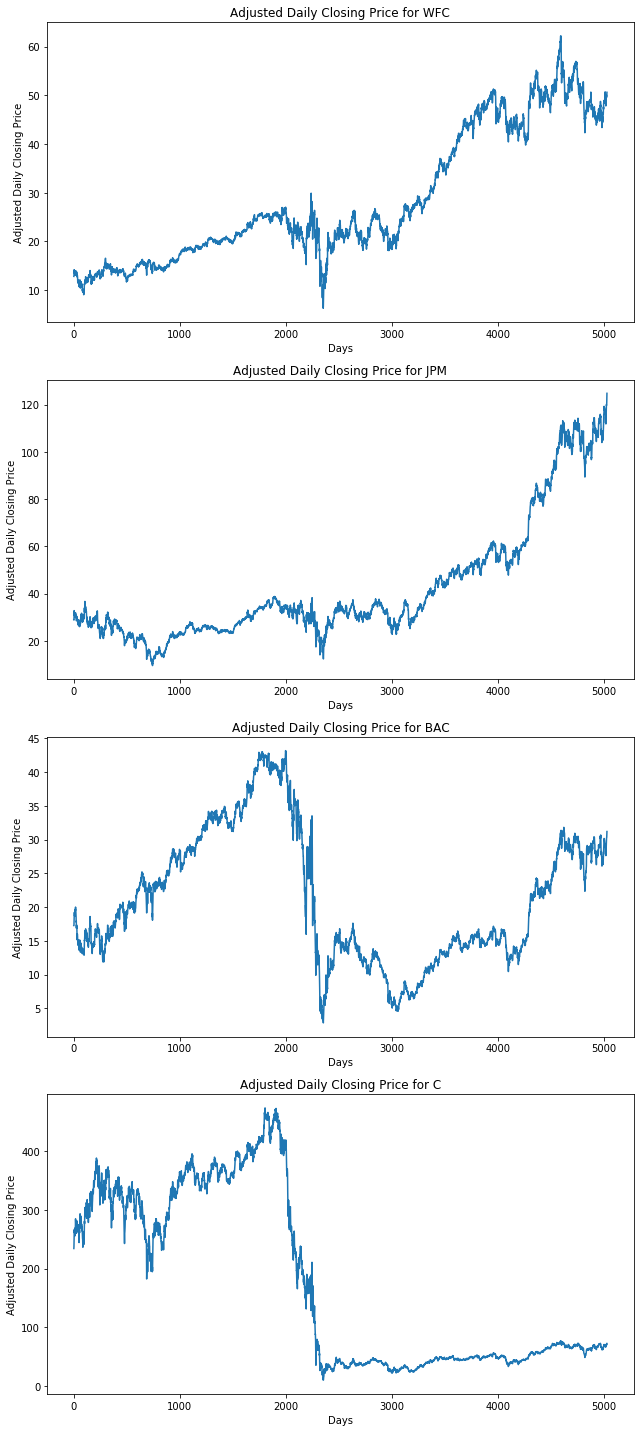

In [7]:
# Plotting Adjusted Daily Closing Price with respect to time.

days = list(range(len(df)))

fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    t = tickers[i]
    adj_close_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['adjusted_close', t])].tolist()
    
    ax[i].plot(days, adj_close_t)
    ax[i].set_title('Adjusted Daily Closing Price for {}'.format(t))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Adjusted Daily Closing Price')
    
plt.show()

It appears that there is an upward trend in all 4 stocks initially until about day 2300, then a sharp almost instaneous downward trend, followed by a slow upward trend until day 5000.

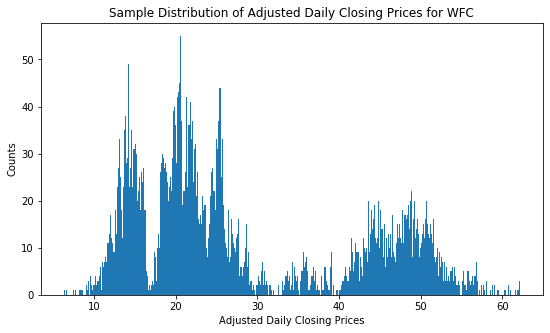

Statistics for Above Distribution
count    5031.000000
mean       28.466109
std        13.482288
min         6.276300
25%        18.580600
50%        23.314900
75%        43.126300
max        62.175200
Name: adjusted_close_WFC, dtype: float64



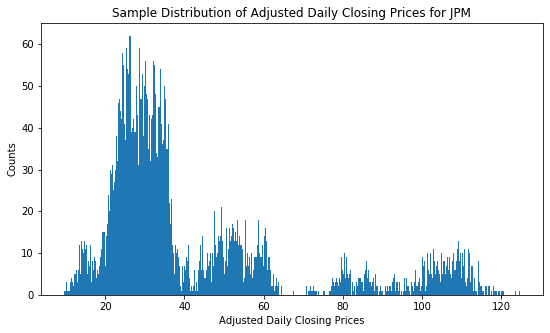

Statistics for Above Distribution
count    5031.000000
mean       42.769751
std        26.031430
min         9.534400
25%        26.027500
50%        32.438100
75%        51.375000
max       124.790000
Name: adjusted_close_JPM, dtype: float64



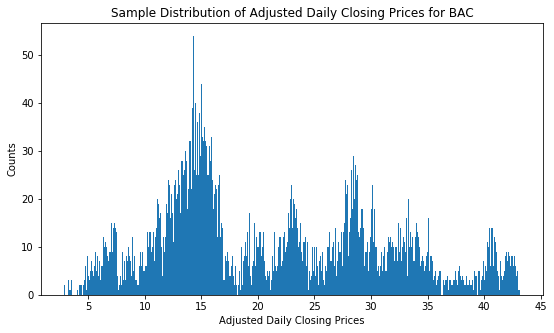

Statistics for Above Distribution
count    5031.000000
mean       21.351440
std         9.760418
min         2.831100
25%        13.766300
50%        19.427200
75%        28.884400
max        43.195000
Name: adjusted_close_BAC, dtype: float64



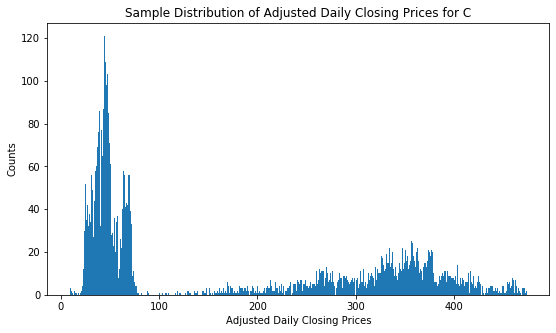

Statistics for Above Distribution
count    5031.000000
mean      174.771051
std       149.176072
min         9.480500
25%        44.343800
50%        68.622900
75%       333.506650
max       474.080800
Name: adjusted_close_C, dtype: float64



In [8]:
# Plotting the distribution of Adjusted Daily Closing Prices

for i in range(len(tickers)):
    data = df['_'.join(['adjusted_close', tickers[i]])]
    fig, ax = plt.subplots(figsize=(9,5))
    ax.hist(data.tolist(), bins=500)
    ax.set_title('Sample Distribution of Adjusted Daily Closing Prices for {}'.format(tickers[i]))
    ax.set_xlabel('Adjusted Daily Closing Prices')
    ax.set_ylabel('Counts')
    plt.show()
    print('Statistics for Above Distribution')
    print(data.describe())
    print()

The distribution of Adjusted Daily Closing Prices appears log-normal which is the distribution type that prices should approximately follow in theory.

In [9]:
# Calculating the log adjusted closing prices, and log adjusted daily returns

for t in tickers:
    df['_'.join(['log_adj_close', t])] = np.log(df['_'.join(['adjusted_close', t])])
    df['_'.join(['log_adj_daily_returns', t])] = df['_'.join(['log_adj_close', t])].shift(1) - df['_'.join(['log_adj_close', t])]
    df = df.dropna(subset=['_'.join(['log_adj_daily_returns', t])])

We are calculating the log of Adjusted Daily Closing Price as well as the difference between the logs of Adjusted Daily Closing Price because if Adjusted Daily Closing Price is log-normal distributed, then the distributions of these values should be normally distributed. This is because the log of a log-normally distributed variable should be normally distributed, and the sum (or difference) of independently normally distributed variables should also be normally distributed. (We are assuming each Adjusted Daily Closing Price is independently distributed from others, which is approximately true.)

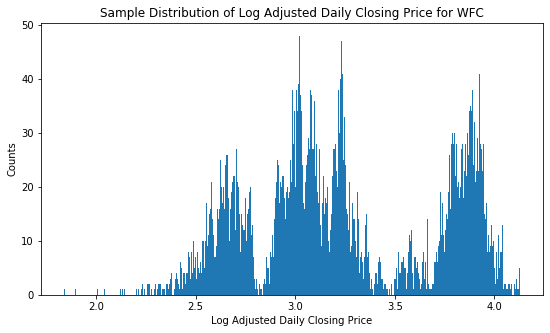

Statistics for Above Distribution
count    5027.000000
mean        3.238465
std         0.467642
min         1.836781
25%         2.921639
50%         3.148505
75%         3.763072
max         4.129956
Name: log_adj_close_WFC, dtype: float64



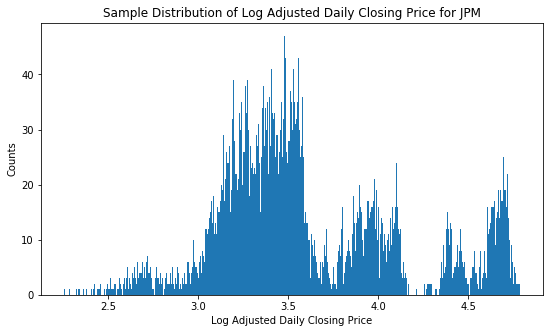

Statistics for Above Distribution
count    5027.000000
mean        3.607864
std         0.517362
min         2.254906
25%         3.259085
50%         3.478967
75%         3.938404
max         4.787158
Name: log_adj_close_JPM, dtype: float64



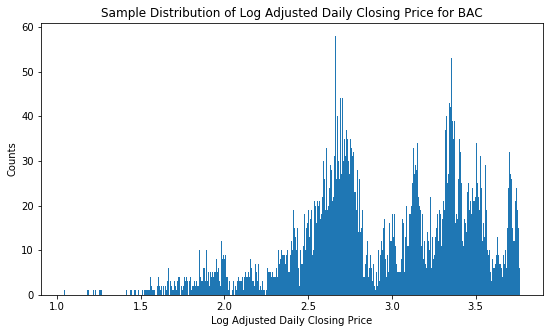

Statistics for Above Distribution
count    5027.000000
mean        2.944008
std         0.505067
min         1.040665
25%         2.622216
50%         2.962227
75%         3.362836
max         3.765725
Name: log_adj_close_BAC, dtype: float64



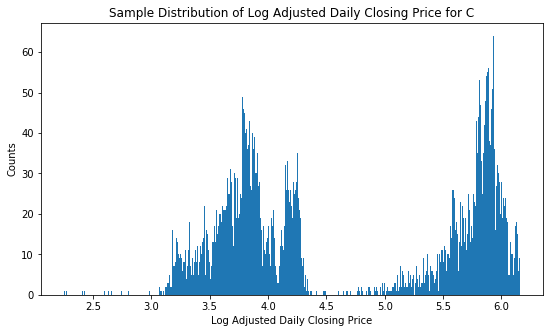

Statistics for Above Distribution
count    5027.000000
mean        4.692818
std         1.019300
min         2.249237
25%         3.791923
50%         4.228532
75%         5.809912
max         6.161378
Name: log_adj_close_C, dtype: float64



In [10]:
# Plotting the distribution of Log Adjusted Daily Closing Price

for i in range(len(tickers)):
    data = df['_'.join(['log_adj_close', tickers[i]])]
    fig, ax = plt.subplots(figsize=(9,5))
    ax.hist(data.tolist(), bins=500)
    ax.set_title('Sample Distribution of Log Adjusted Daily Closing Price for {}'.format(tickers[i]))
    ax.set_xlabel('Log Adjusted Daily Closing Price')
    ax.set_ylabel('Counts')
    plt.show()
    print('Statistics for Above Distribution')
    print(data.describe())
    print()

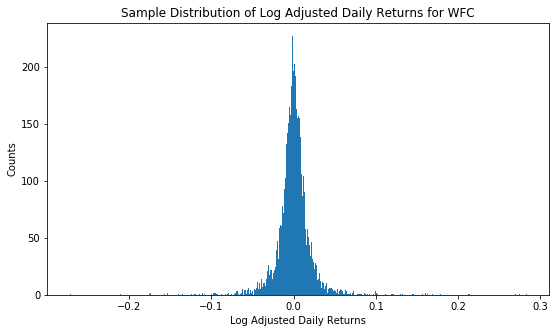

Statistics for Above Distribution
count    5027.000000
mean        0.000269
std         0.023491
min        -0.272103
25%        -0.007963
50%         0.000152
75%         0.008262
max         0.283404
Name: log_adj_daily_returns_WFC, dtype: float64



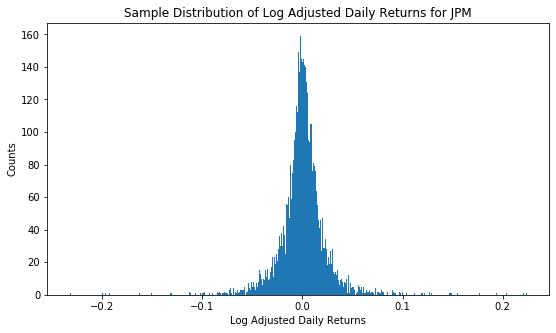

Statistics for Above Distribution
count    5027.000000
mean        0.000284
std         0.024241
min        -0.232277
25%        -0.008984
50%         0.000175
75%         0.009647
max         0.223916
Name: log_adj_daily_returns_JPM, dtype: float64



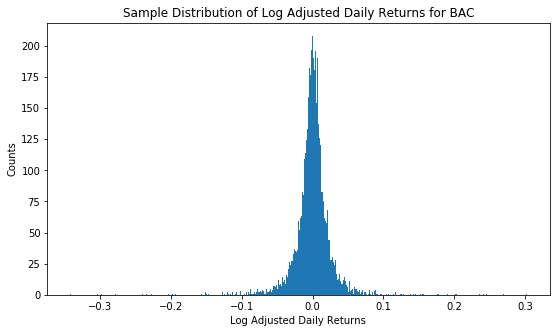

Statistics for Above Distribution
count    5027.000000
mean        0.000112
std         0.028746
min        -0.342067
25%        -0.009586
50%         0.000215
75%         0.009974
max         0.302101
Name: log_adj_daily_returns_BAC, dtype: float64



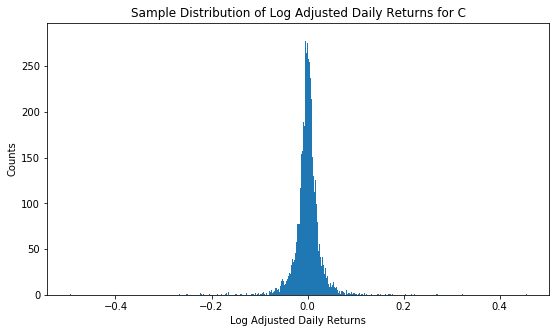

Statistics for Above Distribution
count    5027.000000
mean       -0.000241
std         0.030368
min        -0.494698
25%        -0.009880
50%         0.000000
75%         0.010000
max         0.456316
Name: log_adj_daily_returns_C, dtype: float64



In [11]:
# Plotting the distribution of Log Adjusted Daily Returns

for i in range(len(tickers)):
    data = df['_'.join(['log_adj_daily_returns', tickers[i]])]
    fig, ax = plt.subplots(figsize=(9,5))
    ax.hist(data.tolist(), bins=500)
    ax.set_title('Sample Distribution of Log Adjusted Daily Returns for {}'.format(tickers[i]))
    ax.set_xlabel('Log Adjusted Daily Returns')
    ax.set_ylabel('Counts')
    plt.show()
    print('Statistics for Above Distribution')
    print(data.describe())
    print()

Although the distribution of log Adjusted Daily Closing Price doesn't appear to be too normal, the distribution of Log Adjusted Daily Returns appears to visually fit a normal distribution well. Therefore we are probably safe in make our assumptions about log-normal prices, and independently distributed prices.

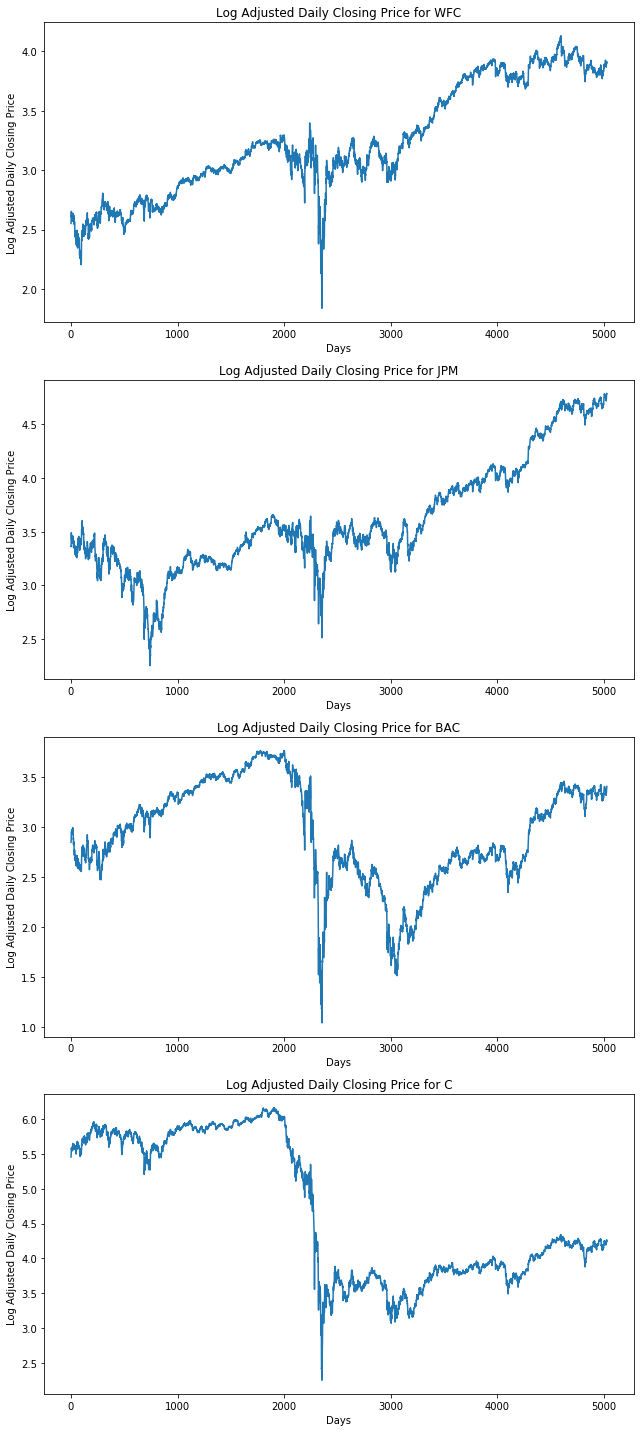

In [12]:
# Plotting Adjusted Daily Returns with respect to time

days = list(range(len(df)))
fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    log_adj_close_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['log_adj_close', tickers[i]])].tolist()
    ax[i].plot(days, log_adj_close_t)
    ax[i].set_title('Log Adjusted Daily Closing Price for {}'.format(tickers[i]))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Log Adjusted Daily Closing Price')
    
plt.show()

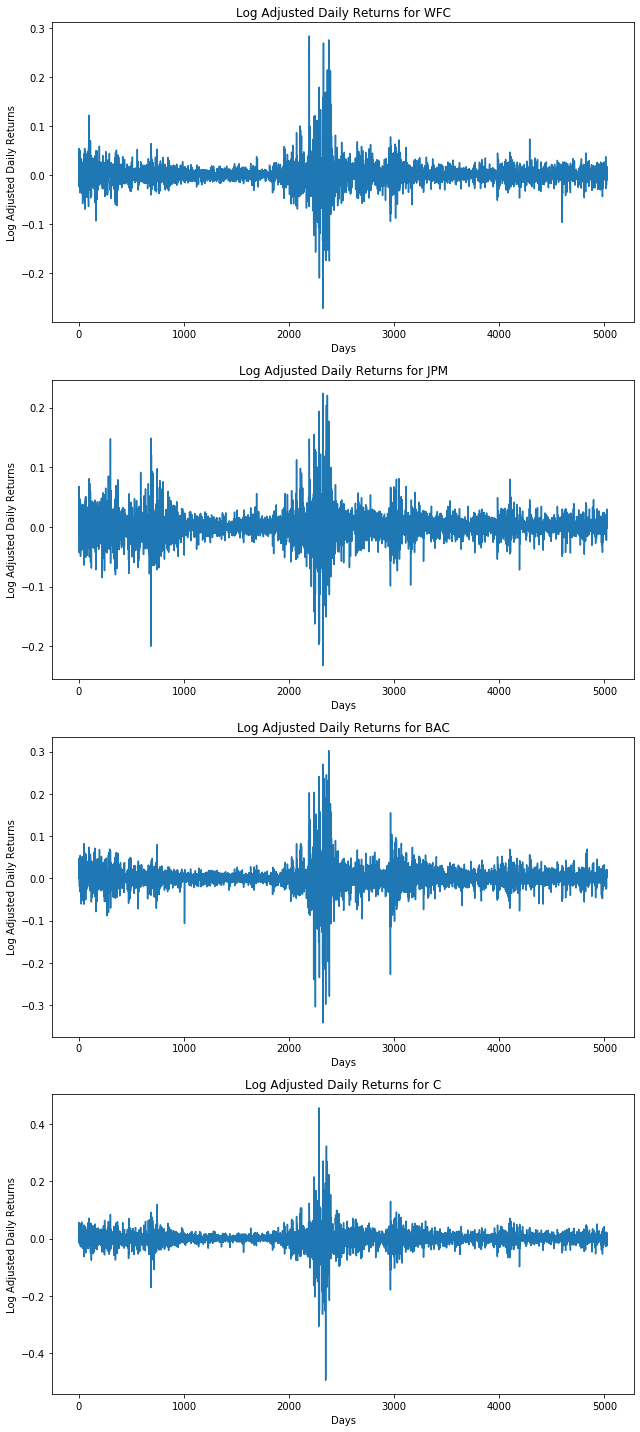

In [13]:
# Plotting Adjusted Daily Returns with respect to time
days = list(range(len(df)))
fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    log_adj_daily_returns_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['log_adj_daily_returns', tickers[i]])].tolist()
    ax[i].plot(days, log_adj_daily_returns_t)
    ax[i].set_title('Log Adjusted Daily Returns for {}'.format(tickers[i]))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Log Adjusted Daily Returns')
    
plt.show()

The time series of log Adjusted Daily Closing Price appears similar to the time series of Adjusted Daily Closing Price. This is as expected and not unusual because we are just taking a log a variable and thus the overall shape of the graph should not be affected. On the other hand the time series of log Adjusted Daily Returns appears to fluctuate about zero where the magnitude of the fluctuation does not change too much except for at a few pivitol days. This makes sense with respect to its Gaussian distribution, because the Gaussian distribution alots small probabilities to large magnitudes of log Adjusted Daily Return which means there should not be too many days where we see a huge value for log Adjusted Daily Return.

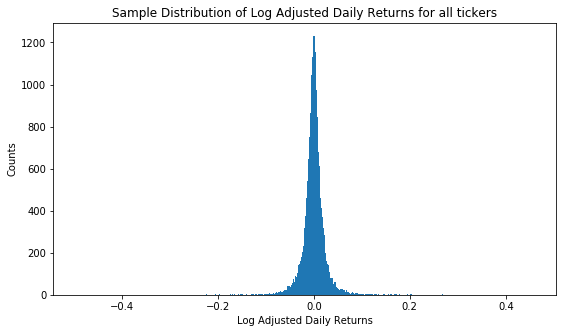

Statistics for Distribution
count    20108.000000
mean         0.000106
std          0.026869
min         -0.494698
25%         -0.009072
50%          0.000000
75%          0.009399
max          0.456316
dtype: float64


In [14]:
# Plotting the distribution of Log Adjusted Daily Returns for all Tickers

data = []
for i in range(len(tickers)):
    data = data + df['_'.join(['log_adj_daily_returns', tickers[i]])].tolist()
data = pd.Series(data)

fig, ax = plt.subplots(figsize=(9,5))
ax.hist(data.tolist(), bins=500)
ax.set_title('Sample Distribution of Log Adjusted Daily Returns for all tickers')
ax.set_xlabel('Log Adjusted Daily Returns')
ax.set_ylabel('Counts')
plt.show()
print('Statistics for Distribution')
print(data.describe())

#### Text Data

The first thing we will check are the lengths of our raw documents.

In [14]:
# Constructing doc_lengths: a list of lengths of all 8-K forms before they are normalized

doc_lengths_paths_dict = {}

for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        doc_lengths_paths_dict[len(raw_doc_text)] = doc_path

In [15]:
print("Largest document has: {} charcters".format(max(doc_lengths_paths_dict.keys())))
print("Smallest document has: {} charcters".format(min(doc_lengths_paths_dict.keys())))
largest_doc_path = doc_lengths_paths_dict[max(doc_lengths_paths_dict.keys())]
smallest_doc_path = doc_lengths_paths_dict[min(doc_lengths_paths_dict.keys())]

Largest document has: 125997383 charcters
Smallest document has: 3548 charcters


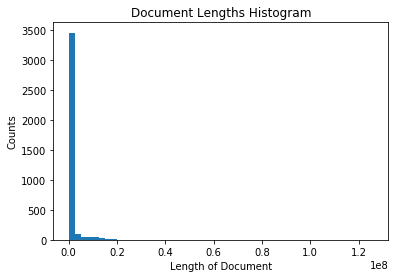

In [16]:
fig, ax = plt.subplots()
ax.hist(doc_lengths_paths_dict.keys(), bins=50)
ax.set_title('Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

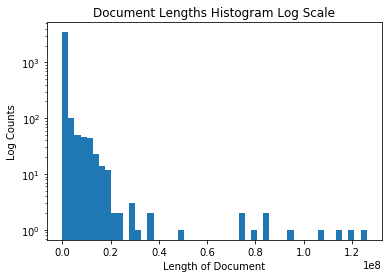

In [17]:
fig, ax = plt.subplots()
ax.hist(doc_lengths_paths_dict.keys(), bins=50, log=True)
ax.set_title('Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

From the above histograms, it appears very few of our documents contain over 30 million characters. Most of our documents seem to have 10 million characters or less with a large emphasize on documents with less than 1 million characters. Since a single characters is about 1 byte in memory, our largest document should be about 125 MB. Therefore we should expect all of our documents to be able to fit into our RAM of 32 GB

#### Text Normalizing

To preprocess our text data, we will first strip it of its x/html tags if the data is encoded this way. Next we will un accent its accented characters, lower case the entire document, and replace all newline/carriage returns with spaces. Next we will strip it of its characters that are not alphanumeric, periods, dollar symbols, or percent symbols. Afterwards we will reduce all words to their dictionary lemmas, and strip the document of its stop words (see stop word list for spacy en_cor_web_sm model). Finally we will replace all whitespace characters with regular space characters, and drop words that are longer in length than a certian cutoff.

The structure of our 8-K filing document involves an xml SEC document header packed with metadata about the filing, and one or multiple xml `<DOCUMENT>` tags. These `<DOCUMENT>` tags contain different types of data that are bundled up into the complete submission for the 8-K filing. The data types stored in these `<DOCUMENT>` tags can range from everything including: regular text data such as html, to binary blob data such as jpg images and pdfs. The structure of these `<DOCUMENT>` tags involve a few meta data tags, none of which involve specifying the encoding type of the data that `<DOCUMENT>` tag stores, and a `<TEXT>` tag that stores the actual data.

Since the inclusion of binary blobs in the markdown prevents easy parsing of the filing structure with lxml, we will result to python re statements to extract the relevant `<DOCUMENT>` tags. Though because the meta data tags enclosed in a `<DOCUMENT>` tag do not specify the encoding type of the data enclosed in the `<TEXT>` tag, there does not appear to be an easy quick general solution that extracts the text data `<DOCUMENT>` tags and avoids the binary blob like `<DOCUMENT>` tags. Because of the above issues we will have to suffice ourselves with extracting only the `<DOCUMENT>` tag that contain's the meta data open tag `<TYPE>8-K`. This specific `<DOCUMENT>` tag always contains text data, and represents the data that is used to generate the SEC 8-K form containing the information that is mandated by the SEC, and excluding the exhibit information that is not mandated by the SEC and is given by the company's discretion. Since this `<DOCUMENT>` tag contains all the mandated information by the SEC for a given 8-K filing, we are still extracting the important information bundled in the filing even though we are not extracting all of the textual information.

In [15]:
# Defining Functions and Classes

def extract_8k(doc):
    eight_k = re.findall('<DOCUMENT>\n<TYPE>8-K.*?<SEQUENCE>1(.*?)</DOCUMENT>', doc, re.DOTALL | re.IGNORECASE)
    text = re.findall('<TEXT>(.*?)</TEXT>', eight_k[0], re.DOTALL | re.IGNORECASE)
    return text

def extract_html(doc):
    html = re.findall('<HTML(?:>| .*?>).*?</HTML>', doc, re.DOTALL | re.IGNORECASE)
    return html

def strip_tags(doc):
    # extracting 8-K <DOCUMENT> tag from the filing
    eight_k = extract_8k(doc)
    assert len(eight_k) == 1, 'Check re for 8-K extraction, either multiple 8-K DOCUMENT tags or bad re'
    
    # extracting <html> tag if any
    html = extract_html(eight_k[0])
    assert 0 <= len(html) <= 1, 'Check re for extracting html tags'
    
    # if html exists
    if len(html) == 1:
        html = html[0]
        soup = BeautifulSoup(html, 'lxml')
        stripped = soup.get_text()
    else:
        soup = BeautifulSoup(eight_k[0], 'lxml')
        stripped = soup.get_text()
    
    return stripped

def strip_accented_chars(doc):
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return doc

def strip_special_chars(doc):
    doc = re.sub('[^$A-Za-z0-9%\s.\']', '', doc)
    return doc

def lemmatize(doc):
    document = nlp(doc)
    doc = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in document])
    return doc

def strip_stop_words(doc):
    document = nlp(doc)
    doc = ' '.join([word.text for word in document if not word.is_stop])
    return doc

def strip_large_words(doc, cut_off=20):
    return ' '.join([word for word in doc.split() if len(word) <= cut_off])

def normalize_document(doc, tags_strip=True, accent_char_strip=True, lower_case=True,
                       no_newlines=True, special_char_strip=True, space_nums=True,
                       lemmatize_words=True, remove_stop_words=True, strip_extra_spaces=True,
                       remove_large_words=False, debug=False):
    '''
    Preprocesses the document :param doc: and returns the normalized document.
    
    :param doc: string, document to normalize
    :param xml_strip: bool, set to True to strip the xml tags
    :param accent_char_strip: bool, set to True to replace accented characters with their non accented versions
    :param lower_case: bool, set to True to lower case the document.
    :param no_newlines: bool, set to True to remove all newlines characters and replace them with spaces
    :param special_char_strip: bool, set to True to remove all characters that are 
                                     not letters, numbers, $, ., %, or spaces
    :param lemmatize_words: bool, set to True to map each word to its lemma
    :param remove_stop_words: bool, set to True to remove stop words
    :param strip_extra_spaces: bool, set to True to replace multiple spaces with one
    :param remove_large_words: int, set to the integer cutoff where words larger than :param remove_large_words:
                               are removed from the text. Set to False if there is no cutoff
    
    ---> string, normalized document
    '''
    if debug:
        print('raw length of doc: {}'.format(len(doc)))
        
    # stripping tags
    if tags_strip:
        doc = strip_tags(doc)
    if debug:
        print('stripped tag length: {}'.format(len(doc)))
    
    # stripping accented characters
    if accent_char_strip:
        doc = strip_accented_chars(doc)
    if debug:
        print('altered accents length: {}'.format(len(doc)))
        
    # lower casing the document
    if lower_case:
        doc = doc.lower()
    if debug:
        print('lower casing length: {}'.format(len(doc)))
    
    # removing new lines and carriage returns and replacing them with spaces
    if no_newlines:
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
    if debug:
        print('removing newlines length: {}'.format(len(doc)))
    
    # removing special characters
    if special_char_strip:
        doc = strip_special_chars(doc)
    if debug:
        print('strip special char length: {}'.format(len(doc)))
    
    # lemmatizing the words
    if lemmatize_words:
        doc = lemmatize(doc)
    if debug:
        print('lemmatized doc length: {}'.format(len(doc)))
    
    # stripping stop words
    if remove_stop_words:
        doc = strip_stop_words(doc)
    if debug:
        print('removed stop word length: {}'.format(len(doc)))
    
    # adding spaces in between numbers and remaining special characters
    if space_nums:
        doc = re.sub(r'([\d$%.])', r' \1 ', doc)
    if debug:
        print('spaced num char length: {}'.format(len(doc)))
        
    # Removing large words
    if remove_large_words:
        doc = strip_large_words(doc, cut_off=remove_large_words)
    if debug:
        print('large words removed char length: {}'.format(len(doc)))
        
    # removing extra whitespace
    if strip_extra_spaces:
        doc = re.sub(' +', ' ', doc)
    if debug:
        print('removed extra space length: {}'.format(len(doc)))
    
    return doc

The first thing we will need to confirm is if the re's we constructed for extracting a documents 8-K component, and the html tag (if they exist) works/still works. For the time being the data we will use from each document will only be the text embedded in the 8-K component of the document.

In [19]:
# Checking the extract_8k function
checksout = True
for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        num_of_8k = len(extract_8k(raw_doc_text))
        if num_of_8k != 1:
            checksout = False
            print('Filing: {0}, contains: {1} 8-K portions, check re of extract_8k, and document.'.format(doc_path, num_of_8k))

if checksout:
    print('The re in extract_8k seems to checkout.')

The re in extract_8k seems to checkout.


In [20]:
# Checking the extract_html function
checksout = True
for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        eight_k = extract_8k(raw_doc_text)[0]
        num_html_tags = len(extract_html(eight_k))
        if not (0 <= num_html_tags <= 1):
            checksout = False
            print('Filing: {0}, contains: {1} html tags, check re of extract_html, and document.'.format(doc_path, num_html_tags))

if checksout:
    print('The re in extract_html seems to checkout.')

The re in extract_html seems to checkout.


In each 8-K filing there should be only one `<DOCUMENT>...</DOCUMENT>` tag that contains a:`<TYPE>8-K` tag. There should also be ONLY one `<html ...>...</html>` tag if the document tag contains an html tag. The above cells verify if any of these conditions are violated on the current dataset.

The next thing we will investigate are the lengths of our normalized texts with no word length cut offs.

In [317]:
# Constructing norm_doc_lengths: a list of lengths of Intel's 8-K forms after they are normalized
norm_doc_lengths_paths_dict = {}

for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')    
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        norm_doc = normalize_document(raw_doc_text)
        norm_doc_lengths_paths_dict[len(norm_doc)] = doc_path

In [318]:
print("Largest document has: {} charcters".format(max(norm_doc_lengths_paths_dict.keys())))
print("Smallest document has: {} charcters".format(min(norm_doc_lengths_paths_dict.keys())))
largest_norm_doc_path = norm_doc_lengths_paths_dict[max(norm_doc_lengths_paths_dict.keys())]
smallest_norm_doc_path = norm_doc_lengths_paths_dict[min(norm_doc_lengths_paths_dict.keys())]

Largest document has: 610674 charcters
Smallest document has: 947 charcters


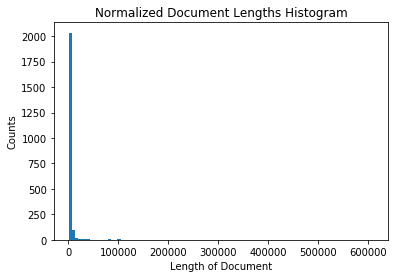

In [319]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths_paths_dict.keys(), bins=100)
ax.set_title('Normalized Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

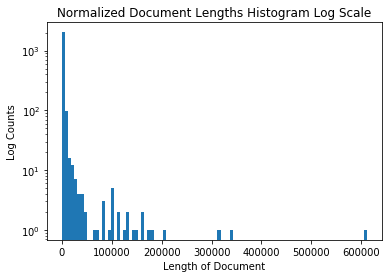

In [320]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths_paths_dict.keys(), bins=100, log=True)
ax.set_title('Normalized Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

Nothing seems to stand out in these histograms so far. The next things we will check are the documents that correspond to the extremums of our histograms just to see if anything stands out about these normalized documents.

In [321]:
# Checking Largest Normalized Document
with open(largest_norm_doc_path) as f:
    largest_norm_doc_raw = f.read()

largest_norm_doc = normalize_document(largest_norm_doc_raw, debug=True)
print()
print(largest_norm_doc_path)
print()
print(largest_norm_doc)

raw length of doc: 78927377
stripped tag length: 731646
altered accents length: 728747
lower casing length: 728747
removing newlines length: 728742
strip special char length: 705357
lemmatized doc length: 686438
removed stop word length: 559678
spaced num char length: 708948
large words removed char length: 708948
removed extra space length: 610674

/media/Data/Programs/FinTech/data/documents/JPM/0000019617-11-000266.txt

 exhibit 9 9 2 q 1 1 1 0 q item 1 2 exhibit 9 9 jpmorgan chase co . consolidate financial highlight unaudite million share headcount ratio datum month end june 3 0 as period end 2 q 1 1 1 q 1 1 4 q 1 0 3 q 1 0 2 q 1 0 2 0 1 1 2 0 1 0 selected income statement datum total net revenue $ 2 6 7 7 9 $ 2 5 2 2 1 $ 2 6 0 9 8 $ 2 3 8 2 4 $ 2 5 1 0 1 $ 5 2 0 0 0 $ 5 2 7 7 2 total noninter expense 1 6 8 4 2 1 5 9 9 5 1 6 0 4 3 1 4 3 9 8 1 4 6 3 1 3 2 8 3 7 3 0 7 5 5 preprovision profita 9 9 3 7 9 2 2 6 1 0 0 5 5 9 4 2 6 1 0 4 7 0 1 9 1 6 3 2 2 0 1 7 provision credit loss 1 8 1 

In [322]:
# Checking Smallest Normalized Document
with open(smallest_norm_doc_path, 'r') as f:
    smallest_norm_doc_raw = f.read()

smallest_norm_doc = normalize_document(smallest_norm_doc_raw, debug=True)
print()
print(smallest_norm_doc_path)
print()
print(smallest_norm_doc)

raw length of doc: 4158
stripped tag length: 2312
altered accents length: 2312
lower casing length: 2312
removing newlines length: 2289
strip special char length: 1876
lemmatized doc length: 1897
removed stop word length: 1765
spaced num char length: 1937
large words removed char length: 1937
removed extra space length: 947

/media/Data/Programs/FinTech/data/documents/C/0000950123-02-007241.txt

 u . s . security exchange commission washington d . c . 2 0 5 4 9 form 8 k current report pursuant section 1 3 1 5 d security exchange act 1 9 3 4 date report date early event report july 2 5 2 0 0 2 citigroup inc . exact registrant specify charter delaware 1 9 9 2 4 5 2 1 5 6 8 0 9 9 state commission irs employer jurisdiction file number identification . incorporation 3 9 9 park avenue new york new york 1 0 0 4 3 address principal executive office zip code 2 1 2 5 5 9 1 0 0 0 registrant telephone number include area code citigroup inc . current report form 8 k item 5 . event . july 2 5 2 0 0 

Nothing seems out of the ordinary about these two normalized documents. The relevant information of the 8-K Document sections of the 8-K filings are still there. The Item #.## sections are still existant in these normalized documents, thus they still contain the information that will be important for analysis, albiet with some noise still

#### Normalized Vocabulary Analysis

The second important component of our text data that we must analyze is the vocabulary (the list of unique words) of our normalized document dataset (corpus).  

In [16]:
# Defining Functions and Classes for constructing vocab.json files

def build_vocab(document, file_path):
    '''
    Adds to the already existing vocabulary file found at :param file_path: the new vocabulary found in the 
    normalized document :param document:.

    :param document: string, normalized document to calculate vocabulary from.
    :param file_path: string, path to vocabulary json file
    
    ---> dict, vocab object, mapping words to their unique integer encodings
    '''
    
    # Loading already established vocabulary
    try:
        with open(file_path, 'r') as f:
            vocab = json.load(f)
            
    except FileNotFoundError:
        vocab  = {}
        
    # Updating vocabulary dictionary
    if not vocab:
        last_word_encoding = 0
    else:
        last_word_encoding = max(vocab.values())
    
    for word in document.split():
        # if a word in the document is not in the current vocab, add it with a word encoding value larger than the largest word encoding value
        if word not in vocab:
            vocab[word] = last_word_encoding + 1
            last_word_encoding = last_word_encoding + 1
            
    with open(file_path, 'w') as f:
        json.dump(vocab, f)
    
    return vocab



def vocab_from_doclist(s, path_to_vocab):
    '''
    
    '''
    doclist = json.loads(s)

    for docpath in doclist:
        with open(docpath, 'r') as f:
            doc = f.read()
            norm_doc = normalize_document(doc)
    
        vocab = build_vocab(norm_doc, path_to_vocab)
        
    return json.dumps(doclist)

First we must create our vocab file and load it into a python object.

In [326]:
# Constructing norm_vocab.json file
for t in tickers:
    df['_'.join(['docs', t])].map(lambda s: vocab_from_doclist(s, os.path.join('logs', 'norm_vocab.json')))

In [329]:
# Opening our norm_vocab.json file    
with open(os.path.join('logs', 'norm_vocab.json'), 'r') as f:
    norm_vocab = json.load(f)

Let's view some of the words in our normalized vocabulary.

In [332]:
print(list(norm_vocab.keys()))

['document', 'false', '0', '7', '2', '9', '1', 'well', 'fargo', 'companymndep', 'shr', 'th', 'int', '.', '5', '8', '%', 'fixtofloat', 'noncum', 'perpetual', 'class', 'pref', 'stock', 'ser', 'qdep', '6', 'r', 'wfcnoncumulativeperpetualclassapreferredstockseriesnmember', 'wfcfixedtofloatingrate', 'noncumulativeperpetualclassapfdstockseriesqmember', 'wfcguaranteeofmediumtermnotesseriesadueoctober', '3', 'ofwellsfargofinancellcmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesymember', 'wfca', 'noncumulativeperpetualconvertibleclassapreferredstockserieslmember', 'usgaapcommonstockmember', 'noncumulativeperpetualclassapfdstockseriesrmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesomember', 'wfcnoncumulativeperpetualclassapreferredstockseriestmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesvmember', 'wfcguaranteeof', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcnoncumulativeperpetualclassapreferredstockserie

There appears to be alot of nonsense words that seem like they could have come from either column names of tables included in the documents, or badly normalized urls. Removing such words from our documents would thus decrease the noise in our data source. Ideally we would alter our normalization process to split such nonsense words up into real words, but this would be a taxing proces. Alternatively we can prescribe a test of some attribute of a word that is designed to flag most of these nonsense words, and if a word violates our test we remove it from the document.

A lot of these nonsense words also appear to be very long in character length, which implies we might test for nonsense words by testing for word length. Lets analyze the distribution of word length and see if we can choose a cut off for word length that captures most of these nonsense words.

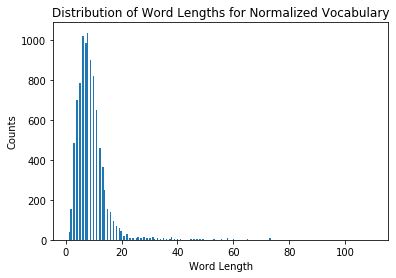

In [334]:
word_lens = list(map(len, norm_vocab.keys()))
fig, ax = plt.subplots()
ax.hist(word_lens, bins=200)
ax.set_title('Distribution of Word Lengths for Normalized Vocabulary')
ax.set_xlabel('Word Length')
ax.set_ylabel('Counts')
plt.show()

It appears that there are very few words with character lengths over 20 characters. This implies that if we choose our cut off to be 20 characters or more, we should not be removing too many words that actually contribute to valuable information when applying our cut off test.

In [338]:
cut_off = 20
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['wfcnoncumulativeperpetualclassapreferredstockseriesnmember', 'wfcfixedtofloatingrate', 'noncumulativeperpetualclassapfdstockseriesqmember', 'wfcguaranteeofmediumtermnotesseriesadueoctober', 'ofwellsfargofinancellcmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesymember', 'noncumulativeperpetualconvertibleclassapreferredstockserieslmember', 'usgaapcommonstockmember', 'noncumulativeperpetualclassapfdstockseriesrmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesomember', 'wfcnoncumulativeperpetualclassapreferredstockseriestmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesvmember', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcnoncumulativeperpetualclassapreferredstockserieswmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesxmember', 'wfcnoncumulativeperpetualclassapreferredstockseriespmember', 'commissionwashington', 'employeridentification', 'iiiwbtpnyseguarantee', 'documentsignaturepursuant', 

In [339]:
cut_off = 18
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['wfcnoncumulativeperpetualclassapreferredstockseriesnmember', 'wfcfixedtofloatingrate', 'noncumulativeperpetualclassapfdstockseriesqmember', 'wfcguaranteeofmediumtermnotesseriesadueoctober', 'ofwellsfargofinancellcmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesymember', 'noncumulativeperpetualconvertibleclassapreferredstockserieslmember', 'usgaapcommonstockmember', 'noncumulativeperpetualclassapfdstockseriesrmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesomember', 'wfcnoncumulativeperpetualclassapreferredstockseriestmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesvmember', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcnoncumulativeperpetualclassapreferredstockserieswmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesxmember', 'wfcnoncumulativeperpetualclassapreferredstockseriespmember', 'commissionwashington', 'employeridentification', 'iiiwbtpnyseguarantee', 'descriptionlocation', 'docum

In [340]:
cut_off = 16
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['wfcnoncumulativeperpetualclassapreferredstockseriesnmember', 'wfcfixedtofloatingrate', 'noncumulativeperpetualclassapfdstockseriesqmember', 'wfcguaranteeofmediumtermnotesseriesadueoctober', 'ofwellsfargofinancellcmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesymember', 'noncumulativeperpetualconvertibleclassapreferredstockserieslmember', 'usgaapcommonstockmember', 'noncumulativeperpetualclassapfdstockseriesrmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesomember', 'wfcnoncumulativeperpetualclassapreferredstockseriestmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesvmember', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcnoncumulativeperpetualclassapreferredstockserieswmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesxmember', 'wfcnoncumulativeperpetualclassapreferredstockseriespmember', 'commissionwashington', 'employeridentification', 'provisionswritten', 'bprecommencement', 'registeredc

From the above inspection real words like: 'undercapitalized' are captured in the 16 character length cutoff while most real words are not captured in the other cutoffs. This implies that we should use a cutoff of 18 characters or more because it is the largest cutoff that captures the least amount of real words.

#### Conclusion

From our exploratory analysis of the raw dataset we can conclude that our pricing data seems to fit the assumptions one usually assumes about stock pricing data. This means that the stock pricing data should be distributed log-normally and implies that the log returns of a stock over a period of time should be distributed normally. Our exploratory analysis of our text data shows there is nothing unusual about our raw text data, and it should fit into memory fine. It also shows that our text preprocessing methods still preserve the important parts of our text data and thus should not pose a future issue for analysis. From these findings we can conclude that our raw text data is useable, our text preprocessing methods are useable, and our price data is useable. Since the log returns of our pricing data (Adjusted Daily Closing Price) appear to fit a Gaussian distribution pretty well, our predictor variable in analysis should be log returns (as opposed to Adjusted Daily Closing Price) because the Gaussian distribution has some nice mathematical properties that might be leveraged further on in the future.

### EDA on Preprocessed Data

In [19]:
# Reseting Raw DataFrame
df = pd.read_csv(os.path.join(path_to_data, 'raw.csv'), parse_dates=['timestamp'])

Checking if the raw DataFrame was reloaded properly.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 37 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null float64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null float64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null f

#### Preprocessing Features

In [21]:
# Defining Functions and Classes for Preprocessing the numerical and text features of the Dataset

def preprocess_features(df, cut_off):
    '''
    Preprocesses data, by normalizing all the documents refrenced in df, calculatating the adjusted logarithmic 
    returns for each stock ticker, creating a vocab.json file for the corresponding dataset, and encoding all
    documents refrenced in df according to the created vocab.json file.
    
    :param df: pd.DataFrame, with structure specified in....
    :param cut_off: int, specifies at what character length do we start removing words from a document in
                    the normalization process
    
    ---> pd.DataFrame, preprocessed DataFrame containing refrences to encoded documents and relevant calculations
    '''
    
    # Deep copying input DataFrame making sure that the input isn't modified as a result of this function
    df = df.copy(deep=True)
    
    def normalize_save_document(link, cut_off, endpoint):
        '''
        Normalize, and save normalized document located at link. The normalized document is saved at location endpoint.
        Returns a path to the saved normalized document.
        
        :param link: string, path to document to be normalized
        :param endpoint: string, path to location to save normalized document
        
        ---> string, path to saved normalized document
        '''
        
        doc_name = os.path.split(link)[-1]
        
        if not os.path.isdir(endpoint):
            os.mkdir(endpoint)
            
        with open(link, 'r') as file:
            raw_document = file.read()
            
        norm_doc = normalize_document(raw_document, remove_large_words=cut_off)
        
        with open(os.path.join(endpoint, doc_name), 'w') as normalized_file:
            normalized_file.write(norm_doc)
        
        return os.path.join(endpoint, doc_name)
      
    def norm_doclist(s):
        '''
        Takes a json formated string :param s: which contains a list of raw document paths, normalizes each document
        in the list, and returns an updated json formated string containing the list of normlized document paths.
        
        :param s: string, json formated, when loaded contains a list of paths to raw documents
        
        ---> string, json formatted, updated list of paths to normalized documents
        '''
        doclist = json.loads(s)
        updated_doclist = []
        
        for docpath in doclist:
            save_point = os.path.join(os.path.split(docpath)[0], 'normalized')
            norm_docpath = normalize_save_document(docpath, cut_off=cut_off, endpoint=save_point)
            updated_doclist.append(norm_docpath)
            
        return json.dumps(updated_doclist)
    
    # Normalizing and updating documents  
    for t in tickers:
        df['_'.join(['docs', t])] = df['_'.join(['docs', t])].map(norm_doclist)
        
    # Preprocessing numerical data
    for t in tickers:
        df['_'.join(['log_adj_close', t])] = np.log(df['_'.join(['adjusted_close', t])])
        df['_'.join(['log_adj_daily_returns', t])] = df['_'.join(['log_adj_close', t])] - df['_'.join(['log_adj_close', t])].shift(-1)
        
    df = df.dropna(subset=['_'.join(['log_adj_daily_returns', tickers[0]])])
    
    def vocab_from_doclist(s, path_to_vocab):
        '''
        Takes a json formated string :param s: that contains a list of document paths, and constructs or adds to an
        already existing vocab.json file, the unique words found in the documents refrenced in the list of document
        paths.
        
        :param s: string, json formated, contains a list of paths to documents
        :param path_to_vocab: string, path to vocab.json file
        
        ---> :param s:
        '''
        
        doclist = json.loads(s)
        
        for docpath in doclist:
            with open(docpath, 'r') as f:
                doc = f.read()
            
            vocab = build_vocab(doc, path_to_vocab)
        
        return json.dumps(doclist) 
    
    # Building vocabulary json file
    path_to_vocab = os.path.join(path_to_data, 'vocab.json')
    
    for t in tickers:
        df['_'.join(['docs', t])].map(lambda s: vocab_from_doclist(s, path_to_vocab))
    
    def encode_doclist(s, vocab):
        '''
        Takes a json formated string :param s: which contains a list of document paths, encodes each document
        in the list according to :param vocab: and saves it as a pickle in a file named encoded, and 
        returns an updated json formated string containing the list of encoded document paths.
        
        :param s: string, json formated, when loaded contains a list of paths to documents to encode
        :param vocab: dict, mapping individual words in documents to another python object that encodes an
                      individual word
        
        ---> string, json formated updated list of paths to encoded document files
        '''
        
        def encode_save_document(docpath):
            '''
            Takes a path to a document and encodes it according to outside state vocab, then saves encoded document
            as a pickle in a file named encoded.
            
            :param docpath: string, path to document to encode
            
            ---> string, path to encoded document pickle
            '''
            
            root, doc_name = os.path.split(docpath)
            
            # Defining save point for encoded documents
            save_point = os.path.join(root, 'encoded')
            if not os.path.isdir(save_point):
                os.mkdir(save_point)
            
            with open(docpath, 'r') as tfile:
                text = tfile.read()
                
            # Encoding document
            encoded_document = [vocab[word] for word in text.split()]
            
            # Saving encoded document
            doc_name = '.'.join([os.path.splitext(doc_name)[0], 'pickle'])
            with open(os.path.join(save_point, doc_name), 'wb') as bfile:
                pickle.dump(encoded_document, bfile)
            
            return os.path.join(save_point, doc_name)
        
        return json.dumps(list(map(encode_save_document, json.loads(s))))
    
    # Encoding documents according to vocabulary
    with open(path_to_vocab, 'r') as f:
        vocab = json.load(f)
    
    for t in tickers:
        df['_'.join(['docs', t])] = df['_'.join(['docs', t])].map(lambda s: encode_doclist(s, vocab))         

    return df

Preprocessing the features of the DataFrame.

In [22]:
preprocessed_df = preprocess_features(df, cut_off=18)

Checking the processed DataFrame. 

In [23]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5029
Data columns (total 45 columns):
timestamp                    5030 non-null datetime64[ns]
open_WFC                     5030 non-null float64
high_WFC                     5030 non-null float64
low_WFC                      5030 non-null float64
close_WFC                    5030 non-null float64
adjusted_close_WFC           5030 non-null float64
volume_WFC                   5030 non-null float64
dividend_amount_WFC          5030 non-null float64
split_coefficient_WFC        5030 non-null float64
open_JPM                     5030 non-null float64
high_JPM                     5030 non-null float64
low_JPM                      5030 non-null float64
close_JPM                    5030 non-null float64
adjusted_close_JPM           5030 non-null float64
volume_JPM                   5030 non-null float64
dividend_amount_JPM          5030 non-null float64
split_coefficient_JPM        5030 non-null float64
open_BAC           

In [24]:
preprocessed_df.head()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,docs_BAC,docs_C,log_adj_close_WFC,log_adj_daily_returns_WFC,log_adj_close_JPM,log_adj_daily_returns_JPM,log_adj_close_BAC,log_adj_daily_returns_BAC,log_adj_close_C,log_adj_daily_returns_C
0,2019-10-22,50.44,51.02,50.23,50.62,50.62,18007709.0,0.0,1.0,123.45,...,[],[],3.924347,0.003166,4.826632,0.009986,3.440418,0.005786,4.277499,0.003475
1,2019-10-21,50.28,50.50,50.18,50.46,50.46,19409100.0,0.0,1.0,122.05,...,[],[],3.921181,0.009758,4.816646,0.024498,3.434632,0.021836,4.274024,0.029250
2,2019-10-18,49.34,50.22,49.32,49.97,49.97,21199500.0,0.0,1.0,120.00,...,[],[],3.911423,0.007230,4.792148,0.001743,3.412797,0.002970,4.244774,0.002009
3,2019-10-17,49.98,50.17,49.48,49.61,49.61,20560100.0,0.0,1.0,120.75,...,[],[],3.904192,0.000403,4.790404,0.005583,3.409827,0.002979,4.242765,0.001438
4,2019-10-16,50.04,50.28,49.45,49.59,49.59,23728400.0,0.0,1.0,119.96,...,"[""/media/Data/Programs/FinTech/data/documents/...",[],3.903789,-0.010431,4.784822,-0.002337,3.406848,0.014691,4.241327,-0.024447


In [25]:
preprocessed_df.tail()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,docs_BAC,docs_C,log_adj_close_WFC,log_adj_daily_returns_WFC,log_adj_close_JPM,log_adj_daily_returns_JPM,log_adj_close_BAC,log_adj_daily_returns_BAC,log_adj_close_C,log_adj_daily_returns_C
5025,1999-11-01,23.500,23.594,23.156,23.438,13.5640,10083800.0,0.0,1.0,86.625,...,[],[],2.607419,-0.021111,3.432670,-0.043183,2.956113,0.006765,5.568721,-0.016260
5026,1999-10-29,24.250,24.531,23.625,23.938,13.8534,11853400.0,0.0,1.0,88.125,...,[],[],2.628531,-0.024500,3.475853,-0.014929,2.949348,0.006816,5.584981,0.002306
5027,1999-10-28,24.063,24.969,23.875,24.531,14.1970,24287800.0,0.0,1.0,85.500,...,[],[],2.653031,0.053643,3.490782,0.067882,2.942532,0.046985,5.582674,0.056094
5028,1999-10-27,22.563,23.250,22.438,23.250,13.4555,11327200.0,0.0,1.0,78.063,...,[],[],2.599388,0.039760,3.422900,0.061522,2.895547,0.046078,5.526580,0.056370
5029,1999-10-26,22.375,22.719,22.219,22.344,12.9310,11607400.0,0.0,1.0,78.313,...,[],"[""/media/Data/Programs/FinTech/data/documents/...",2.559628,0.008426,3.361378,-0.001605,2.849469,0.001077,5.470209,0.014276


Saving preprocessed feature DataFrame to disk.

In [26]:
# Saving preprocessed DataFrame to Disk
preprocessed_df.to_csv(os.path.join(path_to_data, 'preprocessed.csv'), index=False)

#### Extracting Dataset from DataFrame

In [27]:
# Defining Functions and Classes for Preprocessing and Windowing Datasets

def window_df(df, columns, n_trail=1, n_lead=1):
    '''
    :param df: DataFrame, dataframe object where the columns are the features and labels and the rows are days
    :param columns: list of strings, names of the features and labels (columns of df) to be used in the time series
    :param n_trail: int, number of days behind day 0 that will be used to predict days after day 0
    :param n_lead: int, number of days ahead of day 0 that will be predicted
    
    ---> DataFrame, dataframe object structured like a time series where each row represents an element in the time
                    series, and each column is a feature or label a certain amount of days in the future or past.
    '''
    df = df[columns]
    dfs = []
    col_names = []
    
    # Create trailing columns
    for i in range(n_trail, 0, -1):
        dfs.append(df.shift(-i))
        col_names += [(col_name + '(t-{})'.format(i)) for col_name in columns]
        
    # Create leading columns
    for i in range(0, n_lead+1):
        dfs.append(df.shift(i))
        col_names += [(col_name + '(t+{})'.format(i)) for col_name in columns]
        
    agg = pd.concat(dfs, axis=1)
    agg.columns = col_names
    
    agg.dropna(inplace=True)
    
    return agg

def test_function():
    
    test_df = pd.DataFrame([(1, 'a'), (2, 'b'), (3, 'c'),
                            (4, 'd'), (5, 'e'), (6, 'f'),
                            (7, 'g'), (8, 'h'), (9, 'i'),
                            (10, 'j'), (11, 'k'), (12, 'l'),
                            (13, 'm'), (14, 'n'), (15, 'o'),
                            (16, 'p'), (17, 'q'), (18, 'r'),
                            (19, 's'), (20, 't'), (21, 'u'),
                            (22, 'v'), (23, 'w'), (24, 'x'),
                            (25, 'y'), (26, 'z')], columns=['numbers', 'letters'])
    test_df = test_df.reindex(index=test_df.index[::-1])
    print('Test DataFrame:')
    print(test_df)
    df = window_df(test_df, columns=test_df.columns, n_trail=5)
    print()
    print('Windowed DataFrame with a window size of n_trail+1')
    print(df)
    return None

#test_function()

def extract_features(feature_names, ticker, df):
    cols = map(lambda fname: '_'.join([fname, ticker]), feature_names)
    return df[cols]

def extract_dataset(df, feature_names, ticker, n_trail=1, n_lead=1):
    selected_df = extract_features(feature_names, ticker, df)
    windowed_df = window_df(selected_df, selected_df.columns, n_trail=n_trail, n_lead=n_lead)
    dataset = {fname: windowed_df[filter(lambda name: True if fname in name else False, windowed_df.columns)].values
                     for fname in feature_names}
    return dataset

def extract_labels(dataset, label_names):
    labels = {'_'.join([fname, 'target']): dataset[fname][:, -1] for fname in dataset.keys() if fname in label_names}
    features = {fname: dataset[fname][:, :-1] for fname in dataset.keys()}
    return features, labels

def reshape_docs_feature(dataset, seed):
    
    def flatten_docs_feature(docs_feature):
        docs = []
        for timestep in docs_feature:
            docs_list = json.loads(timestep)
            docs.extend(docs_list)
        return docs
    
    def sample_docs(docs_feature, seed):
        np.random.seed(seed)
        docs_names = flatten_docs_feature(docs_feature)
        if len(docs_names) != 0:
            windows_doc_name = np.random.choice(docs_names, size=1)[0]
            with open(windows_doc_name, 'rb') as f:
                windows_doc = pickle.load(f)
            window = windows_doc
        else:
            window = []
        return np.asarray(window)
    
    features = dataset[0]
    labels = dataset[1]

    features_reshaped = {key: (value if key != 'docs' 
                               else list(map(lambda docf: sample_docs(docf, seed), value))) 
                         for key, value in features.items()}

    return features_reshaped, labels

def filter_dataset(dataset):
    features = dataset[0]
    labels = dataset[1]
    mask = [(sample.shape[0] != 0) for sample in features['docs']]
    features_filtered = {key: (value[mask, :] if key != 'docs'
                               else [value[i] for i in range(len(mask)) if mask[i]])
                         for key, value in features.items()}
    labels_filtered = {key: value[mask] for key, value in labels.items()}
    return features_filtered, labels_filtered

def add_datasets(dataset_1, dataset_2):
    features_1 = dataset_1[0]
    labels_1 = dataset_1[1]
    features_2 = dataset_2[0]
    labels_2 = dataset_2[1]
    assert (features_1.keys() == features_2.keys()) and (labels_1.keys() == labels_2.keys())
    feature_names = features_1.keys()
    label_names = labels_1.keys()
    features = {fname: (np.concatenate((features_1[fname], features_2[fname]))
                        if fname != 'docs' else features_1[fname] + features_2[fname])
                for fname in feature_names}
    labels = {lname: np.concatenate((labels_1[lname], labels_2[lname])) for lname in label_names}
    return features, labels

def pad_documents(docs_feature):
    shapes = map(lambda arr: arr.shape, docs_feature)
    longest_doc_len = max(map(lambda shape: shape[-1], shapes))
    pad_doc = lambda arr:  np.pad(arr, ((0, longest_doc_len - arr.shape[-1])), constant_values=0)
    return np.stack(list(map(pad_doc, docs_feature)), axis=0)

def pad_dataset(dataset):
    features = dataset[0]
    labels = dataset[1]
    pad_document_feature = lambda fname, f: (fname, pad_documents(f)) if fname == 'docs' else (fname, f)
    padded_features = dict(map(lambda item: pad_document_feature(item[0], item[1]), features.items()))
    return padded_features, labels

def shuffle_dataset(dataset, seed):
    np.random.seed(seed)
    features = dataset[0]
    labels = dataset[1]
    dataset_size = len(next(iter(features.values())))
    shuffled_indices = np.random.choice(dataset_size, size=dataset_size, replace=False)
    features_shuffled = {fname: feature[shuffled_indices] for fname, feature in features.items()}
    labels_shuffled = {lname: label[shuffled_indices] for lname, label in labels.items()}
    return features_shuffled, labels_shuffled

In [28]:
def preprocess_dataset(feature_names, label_feature_names, window_size, tickers, df, seed):
    datasets = map(lambda t: extract_dataset(df, feature_names, ticker=t, n_trail=window_size-1), tickers)
    datasets = map(lambda ds: extract_labels(ds, label_feature_names), datasets)
    datasets = map(lambda ds: reshape_docs_feature(ds, seed), datasets)
    datasets = map(filter_dataset, datasets)
    dataset = reduce(add_datasets, datasets)
    dataset = pad_dataset(dataset)
    dataset = shuffle_dataset(dataset, seed)
    return dataset

Loading preprocessed feature DataFrame from disk.

In [29]:
preprocessed_df = pd.read_csv(os.path.join(path_to_data, 'preprocessed.csv'), parse_dates=['timestamp'])

Checking out if the DataFrame was loaded properly.

In [30]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5030 entries, 0 to 5029
Data columns (total 45 columns):
timestamp                    5030 non-null datetime64[ns]
open_WFC                     5030 non-null float64
high_WFC                     5030 non-null float64
low_WFC                      5030 non-null float64
close_WFC                    5030 non-null float64
adjusted_close_WFC           5030 non-null float64
volume_WFC                   5030 non-null float64
dividend_amount_WFC          5030 non-null float64
split_coefficient_WFC        5030 non-null float64
open_JPM                     5030 non-null float64
high_JPM                     5030 non-null float64
low_JPM                      5030 non-null float64
close_JPM                    5030 non-null float64
adjusted_close_JPM           5030 non-null float64
volume_JPM                   5030 non-null float64
dividend_amount_JPM          5030 non-null float64
split_coefficient_JPM        5030 non-null float64
open_BAC           

In [31]:
preprocessed_df.head()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,docs_BAC,docs_C,log_adj_close_WFC,log_adj_daily_returns_WFC,log_adj_close_JPM,log_adj_daily_returns_JPM,log_adj_close_BAC,log_adj_daily_returns_BAC,log_adj_close_C,log_adj_daily_returns_C
0,2019-10-22,50.44,51.02,50.23,50.62,50.62,18007709.0,0.0,1.0,123.45,...,[],[],3.924347,0.003166,4.826632,0.009986,3.440418,0.005786,4.277499,0.003475
1,2019-10-21,50.28,50.50,50.18,50.46,50.46,19409100.0,0.0,1.0,122.05,...,[],[],3.921181,0.009758,4.816646,0.024498,3.434632,0.021836,4.274024,0.029250
2,2019-10-18,49.34,50.22,49.32,49.97,49.97,21199500.0,0.0,1.0,120.00,...,[],[],3.911423,0.007230,4.792148,0.001743,3.412797,0.002970,4.244774,0.002009
3,2019-10-17,49.98,50.17,49.48,49.61,49.61,20560100.0,0.0,1.0,120.75,...,[],[],3.904192,0.000403,4.790404,0.005583,3.409827,0.002979,4.242765,0.001438
4,2019-10-16,50.04,50.28,49.45,49.59,49.59,23728400.0,0.0,1.0,119.96,...,"[""/media/Data/Programs/FinTech/data/documents/...",[],3.903789,-0.010431,4.784822,-0.002337,3.406848,0.014691,4.241327,-0.024447


In [32]:
preprocessed_df.tail()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,docs_BAC,docs_C,log_adj_close_WFC,log_adj_daily_returns_WFC,log_adj_close_JPM,log_adj_daily_returns_JPM,log_adj_close_BAC,log_adj_daily_returns_BAC,log_adj_close_C,log_adj_daily_returns_C
5025,1999-11-01,23.500,23.594,23.156,23.438,13.5640,10083800.0,0.0,1.0,86.625,...,[],[],2.607419,-0.021111,3.432670,-0.043183,2.956113,0.006765,5.568721,-0.016260
5026,1999-10-29,24.250,24.531,23.625,23.938,13.8534,11853400.0,0.0,1.0,88.125,...,[],[],2.628531,-0.024500,3.475853,-0.014929,2.949348,0.006816,5.584981,0.002306
5027,1999-10-28,24.063,24.969,23.875,24.531,14.1970,24287800.0,0.0,1.0,85.500,...,[],[],2.653031,0.053643,3.490782,0.067882,2.942532,0.046985,5.582674,0.056094
5028,1999-10-27,22.563,23.250,22.438,23.250,13.4555,11327200.0,0.0,1.0,78.063,...,[],[],2.599388,0.039760,3.422900,0.061522,2.895547,0.046078,5.526580,0.056370
5029,1999-10-26,22.375,22.719,22.219,22.344,12.9310,11607400.0,0.0,1.0,78.313,...,[],"[""/media/Data/Programs/FinTech/data/documents/...",2.559628,0.008426,3.361378,-0.001605,2.849469,0.001077,5.470209,0.014276


Extracting the preprocessed dataset from the DataFrame.

In [33]:
dataset = preprocess_dataset(['log_adj_daily_returns', 'docs'], ['log_adj_daily_returns'],
                             window_size=5, tickers=tickers, df=preprocessed_df, seed=seed)

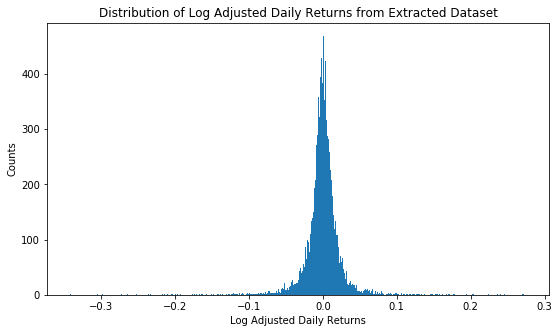

Statistics for Distribution
count    9880.000000
mean       -0.000060
std         0.027437
min        -0.342067
25%        -0.008442
50%         0.000000
75%         0.008991
max         0.275344
dtype: float64


In [37]:
# Plotting the Distribution of our Target Variable (Log Adjusted Daily Returns) from our extracted Dataset

data = pd.Series(dataset[1]['log_adj_daily_returns_target'])

fig, ax = plt.subplots(figsize=(9,5))
ax.hist(data.tolist(), bins=500)
ax.set_title('Distribution of Log Adjusted Daily Returns from Extracted Dataset')
ax.set_xlabel('Log Adjusted Daily Returns')
ax.set_ylabel('Counts')
plt.show()
print('Statistics for Distribution')
print(data.describe())

From the above statistics and distribution, our extracted and preprocessed dataset targets, seem to approximately preserve the distribution of the DataFrame feature they are derived from. This is important because it confirms our preprocessed Dataset is still a representative sample of our original raw data stored in the DataFrame.

Splitting dataset into training and testing datasets.

In [38]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

In [39]:
train_dataset, test_dataset = split_dataset(dataset, train_size=0.75, random_state=seed)

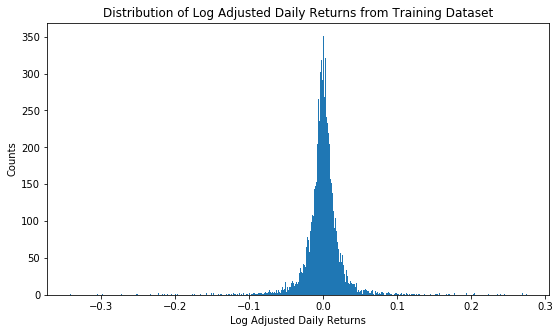

Statistics for Distribution
count    7410.000000
mean       -0.000093
std         0.027972
min        -0.342067
25%        -0.008335
50%         0.000000
75%         0.009070
max         0.275344
dtype: float64


In [40]:
# Plotting the Distribution of our Target Variable (Log Adjusted Daily Returns) from our Train Dataset

data = pd.Series(train_dataset[1]['log_adj_daily_returns_target'])

fig, ax = plt.subplots(figsize=(9,5))
ax.hist(data.tolist(), bins=500)
ax.set_title('Distribution of Log Adjusted Daily Returns from Training Dataset')
ax.set_xlabel('Log Adjusted Daily Returns')
ax.set_ylabel('Counts')
plt.show()
print('Statistics for Distribution')
print(data.describe())

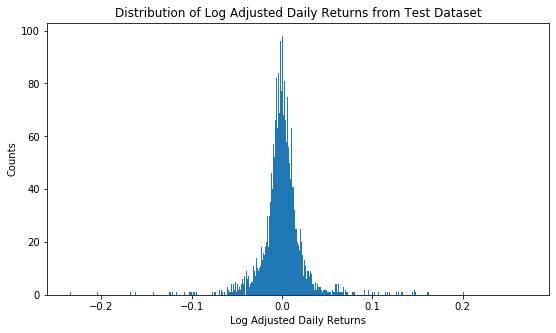

Statistics for Distribution
count    2470.000000
mean        0.000039
std         0.025769
min        -0.234752
25%        -0.008755
50%        -0.000202
75%         0.008726
max         0.270570
dtype: float64


In [41]:
# Plotting the Distribution of our Target Variable (Log Adjusted Daily Returns) from our Test Dataset

data = pd.Series(test_dataset[1]['log_adj_daily_returns_target'])

fig, ax = plt.subplots(figsize=(9,5))
ax.hist(data.tolist(), bins=500)
ax.set_title('Distribution of Log Adjusted Daily Returns from Test Dataset')
ax.set_xlabel('Log Adjusted Daily Returns')
ax.set_ylabel('Counts')
plt.show()
print('Statistics for Distribution')
print(data.describe())

Again, the above distributions and statistics suggest that our sample datasets, both train and test, seem to approximately preserve the distribution of the original dataset. This is important because if our sampling strategy doesn't preserve the distribution of the original dataset, then our model will learn the properties of one distribution, but be tested on a distribution that is not statistically similar. 

Saving our train, test, and full datasets to disk.

In [42]:
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'wb') as f:
    pickle.dump(train_dataset, f, protocol=4)

In [43]:
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'wb') as f:
    pickle.dump(test_dataset, f, protocol=4)

In [44]:
with open(os.path.join(path_to_data, 'dataset.pickle'), 'wb') as f:
    pickle.dump(dataset, f, protocol=4)

## Modeling

### Baseline Model

The baseline model is the bare minimum model we can manually construct from just our Exploratory Data Analysis. This model will give us baselines that hopefully our trained models will beat. Since the problem we are dealing with is a regression problem with only one target variable, we can represent any model that fits this problem description as: 

$$E(Y|X=X) = W \cdot X + b$$

In the case of simple linear regression then $X$ directly represents the input features to the model, and $W$ and $b$ the weights and biases that the model learns. On the other hand if this equation represents a deep model architecture, then $W$ and $b$ would represent only the weights and biases that the model learns for the **output layer**. This implies that $X$ would be a function of the input features to the model and would represent the input passed to the output layer of the model, or in other words $X$ represents the features the previous layers of the model **learned** to extract from the given original input features.

We can express our baseline model as one that predicts the expected value of the target variable no matter what the predictor variable happens to be. If we assume that there exists a relation between our predictor variables and target variable, and we average across all values of our predictor variables, then we find that any trained model of the relationship between predictor and target variables should on average predict the expected value of the target variable. This means that the bare minimum we can ask a model is that on average it predicts the expected value of the target variable. This implies that if we were to design a model that predicts the target variable without taking the predictor variable into account, then inorder to satisfy the bare minimum constraint, this model would need to predict the mean of our target variable. Mathematically we can express or baseline model as:

$E(Y|X=X) = E(Y) = \mu = W \cdot X + b$ such that $W = 0$ in order to satisfy the input independent constraint.

This implies $b = \mu$.

This also implies that we can convert any model to a model equivalent to the baseline model, as long as we initialize its output layers weights to zero, and its bias to the expected value of our target variable.


In our specific case we know from our exploratory data analysis that the means of all our target variables, logarithmic adjusted returns, are close to zero for each stock. This is also supported by theory, which predicts that the logarthimic return on a stock should follow a normal distribution centered around zero (or at least very closely conform to a normal distribution). This means to build our baseline model we must create a linear regression model where both the weights and bias are initialized to zero.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


Defining baseline model.

In [2]:
def baseline_model(output_bias_init):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(inputs['log_adj_daily_returns'])}
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Building baseline model.

In [3]:
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}

baseline_m = build_compiled_model(baseline_model, hparams, loss=LOSS,
                                  optimizer=OPTIMIZER, metrics=METRICS, callbacks=CALLBACKS)

Evaluating baseline model.

In [4]:
X_train, y_train = train_dataset
X_test, y_test = test_dataset
X, y = dataset

baseline_predictions = baseline_m.predict(X_train)
baseline_results_train = baseline_m.evaluate(X_train, y_train, verbose=0)
baseline_results_test = baseline_m.evaluate(X_test, y_test, verbose=0)
baseline_results = baseline_m.evaluate(X, y, verbose=0)

In [5]:
assert all((pred == baseline_predictions[0]) for pred in baseline_predictions)

print('Train Loss for Baseline Model: {}'.format(baseline_results_train))
print('Test Loss for Baseline Model: {}'.format(baseline_results_test))
print('Loss for Baseline Model on Full Dataset: {}'.format(baseline_results))

Train Loss for Baseline Model: 0.0007823239772030066
Test Loss for Baseline Model: 0.0006637957513375728
Loss for Baseline Model on Full Dataset: 0.0007526919210724616


### Model 0 (without Text Features)

#### Model Definition:

In [6]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [7]:
def gen_print_model_stats(model, path, model_name):
    m = model()
    if not os.path.exists(path):
        os.makedirs(path)
    fname = os.path.join(path, model_name)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [8]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

gen_print_model_stats(model_0_notext, os.path.join('logs', 'models', 'model_0_notext'), 'model_0_notext')

Model: "model_0_notext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
log_adj_daily_returns (InputLay [(None, 5)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 5, 1)         0           log_adj_daily_returns[0][0]      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           4352        lambda[0][0]                     
__________________________________________________________________________________________________
docs (InputLayer)               [(None, None)]       0                                            
_____________________________________________________________________________________

Graph of Model:
![title](logs/models/model_0_notext/model_0_notext.png)

#### Unit Testing Model

##### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(inputs['log_adj_daily_returns'])}
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [4]:
def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    output_bias_init = 0
    
    baseline_m = build_compiled_model(baseline_model, {'output_bias_init': output_bias_init},
                                      loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    hparams = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    m1 = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [5]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_0_notext, baseline_model, batch_size=8, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


##### 2. Testing if the model trained on real data performs better than the model trained on null data.

###### Using Null Data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if (feature_name == 'log_adj_daily_returns'):
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif (feature_name == 'docs'):
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Training model on null features.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=128, seed=seed)
X_null = null_features(X)

epochs = 100
batch_size = 64
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}


m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X_null, y, batch_size=batch_size, epochs=epochs)

Train on 128 samples
Epoch 1/100
128/128 [==============================] - 3s 21ms/sample - loss: 4.2745e-04
Epoch 2/100
128/128 [==============================] - 0s 101us/sample - loss: 4.0872e-04
Epoch 3/100
128/128 [==============================] - 0s 84us/sample - loss: 4.0768e-04
Epoch 4/100
128/128 [==============================] - 0s 104us/sample - loss: 4.0531e-04
Epoch 5/100
128/128 [==============================] - 0s 105us/sample - loss: 3.9986e-04
Epoch 6/100
128/128 [==============================] - 0s 110us/sample - loss: 4.0209e-04
Epoch 7/100
128/128 [==============================] - 0s 109us/sample - loss: 3.9890e-04
Epoch 8/100
128/128 [==============================] - 0s 95us/sample - loss: 4.0073e-04
Epoch 9/100
128/128 [==============================] - 0s 92us/sample - loss: 4.0064e-04
Epoch 10/100
128/128 [==============================] - 0s 108us/sample - loss: 3.9801e-04
Epoch 11/100
128/128 [==============================] - 0s 91us/sample - loss: 3.9

Epoch 91/100
128/128 [==============================] - 0s 93us/sample - loss: 4.0146e-04
Epoch 92/100
128/128 [==============================] - 0s 94us/sample - loss: 4.0286e-04
Epoch 93/100
128/128 [==============================] - 0s 91us/sample - loss: 4.0003e-04
Epoch 94/100
128/128 [==============================] - 0s 99us/sample - loss: 3.9854e-04
Epoch 95/100
128/128 [==============================] - 0s 104us/sample - loss: 3.9936e-04
Epoch 96/100
128/128 [==============================] - 0s 92us/sample - loss: 3.9876e-04
Epoch 97/100
128/128 [==============================] - 0s 107us/sample - loss: 3.9827e-04
Epoch 98/100
128/128 [==============================] - 0s 84us/sample - loss: 3.9905e-04
Epoch 99/100
128/128 [==============================] - 0s 100us/sample - loss: 3.9885e-04
Epoch 100/100
128/128 [==============================] - 0s 97us/sample - loss: 3.9865e-04


Evaluating model.

In [5]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [6]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(m_results))

Metrics for model trained on zeroed features.

Loss for Model: 0.00042547193879727274


###### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Training model on actual data.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=128, seed=seed)

epochs = 100
batch_size = 64
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}


m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X, y, batch_size=batch_size, epochs=epochs)

Train on 128 samples
Epoch 1/100
128/128 [==============================] - 3s 21ms/sample - loss: 4.6100e-04
Epoch 2/100
128/128 [==============================] - 0s 98us/sample - loss: 4.3567e-04
Epoch 3/100
128/128 [==============================] - 0s 107us/sample - loss: 4.3054e-04
Epoch 4/100
128/128 [==============================] - 0s 129us/sample - loss: 4.2225e-04
Epoch 5/100
128/128 [==============================] - 0s 104us/sample - loss: 4.1501e-04
Epoch 6/100
128/128 [==============================] - 0s 112us/sample - loss: 4.1262e-04
Epoch 7/100
128/128 [==============================] - 0s 113us/sample - loss: 4.0373e-04
Epoch 8/100
128/128 [==============================] - 0s 111us/sample - loss: 4.0427e-04
Epoch 9/100
128/128 [==============================] - 0s 112us/sample - loss: 4.0029e-04
Epoch 10/100
128/128 [==============================] - 0s 118us/sample - loss: 3.9230e-04
Epoch 11/100
128/128 [==============================] - 0s 123us/sample - loss: 

Evaluating model.

In [5]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [6]:
print()
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(m_results))
print()


Metrics for model trained on actual data.

Loss for Model: 0.0003558132302714512



Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

##### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')


# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Overtraining model on a small sample of the data.

In [4]:
def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    output_bias_init = 0
    hparams = {'output_bias_init': output_bias_init}
    
    m = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    m_history = m.fit(X_small, y_small, batch_size=batch_size, epochs=epochs, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    print()
    
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series for Log Adjusted Daily Returns')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'log_adj_daily_returns')
    
    metrics = ['loss'] + list(map(lambda met: met.name, METRICS))
    for met in metrics:
        plot_metric(m_history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data

Plotting Error against Sample for Before Training, and After Training on the Small Dataset


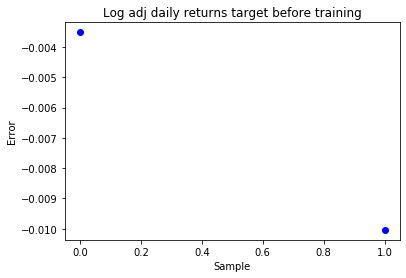

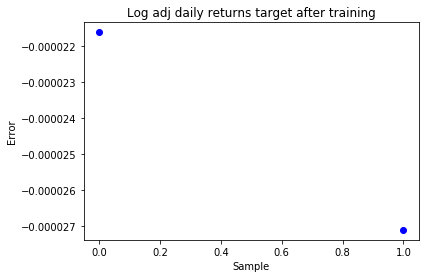


Plotting Each Sample's Time Series for Log Adjusted Daily Returns


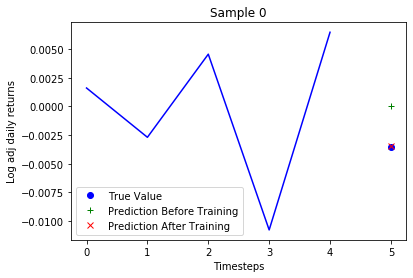

True Target Value: -0.0035051436379571754
Predicted Target Value Before Training: 7.341385753534269e-06
Predicted Target Value After Training: -0.00348352687433362




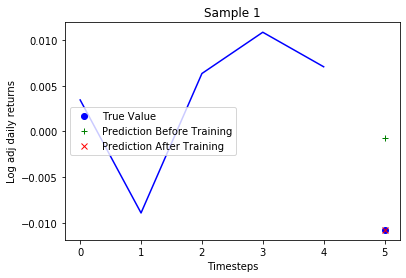

True Target Value: -0.010760221939794423
Predicted Target Value Before Training: -0.0007208752213045955
Predicted Target Value After Training: -0.010733124800026417




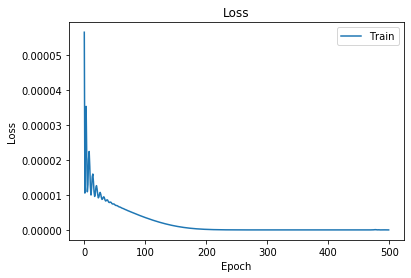

In [5]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)
overfit_small_sample(model_0_notext, batch_size=2, epochs=500, X_small=X_small, y_small=y_small, verbose=0)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

#### Evaluating Model:

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
        
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    
    return None

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Splitting train dataset into train and validation dataset.

In [4]:
train, val = split_dataset(train_dataset, train_size=0.75, random_state=seed)
X_train, y_train = train
X_val, y_val = val

print('Train set size: {}'.format(len(y_train['log_adj_daily_returns_target'])))
print('Validation set size: {}'.format(len(y_val['log_adj_daily_returns_target'])))
print('Test set size: {}'.format(len(test_dataset[1]['log_adj_daily_returns_target'])))

Train set size: 5557
Validation set size: 1853
Test set size: 2470


Training model.

In [5]:
batch_size = 64
epochs = 2

hparams = {'lstm_layer_units': 32, 'output_bias_init': 0}
m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS, callbacks=None)
m_history = m.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 5557 samples, validate on 1853 samples
Epoch 1/2
5557/5557 [==============================] - 4s 686us/sample - loss: 8.0353e-04 - val_loss: 7.8672e-04
Epoch 2/2
5557/5557 [==============================] - 1s 134us/sample - loss: 8.0176e-04 - val_loss: 7.7104e-04


Evaluating model.

In [6]:
# Gathering Data
metrics_train = m.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
metrics_val = m.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
m_preds_train = m.predict(X_train)
m_preds_val = m.predict(X_val)
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_val = (m_preds_val[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_val = y_val['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


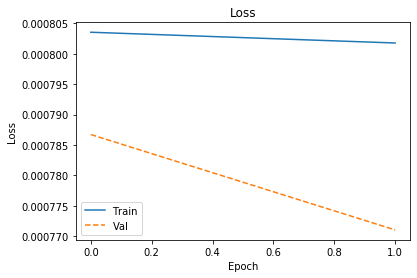

Loss on train dataset: 0.0007875599228051391
Loss on validation dataset: 0.0007710394982165113

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.4984703976965989
Accuracy on validation dataset: 0.5267134376686454


In [7]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(m_history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=m.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

### Model 0

#### Model Definition:

In [8]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [1]:
def gen_print_model_stats(model, path, model_name):
    m = model()
    if not os.path.exists(path):
        os.makedirs(path)
    fname = os.path.join(path, model_name, model_name)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [12]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

gen_print_model_stats(model_0, os.path.join('logs', 'models'), 'model_0')

Model: "model_0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
document_embedder (Model)       (None, 100)          2911400     docs[0][0]                       
__________________________________________________________________________________________________
log_adj_daily_returns (InputLay [(None, 5)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 5, 100)       0           document_embedder[1][0]          
____________________________________________________________________________________________

Graph of Model:
![title](logs/models/model_0/model_0.png)

#### Unit Testing Model

##### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(inputs['log_adj_daily_returns'])}
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [4]:
def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    output_bias_init = 0
    
    baseline_m = build_compiled_model(baseline_model, {'output_bias_init': output_bias_init},
                                      loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    hparams = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    m1 = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [5]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_0, baseline_model, batch_size=8, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


##### 2. Testing if the model trained on real data performs better than the model trained on null data.

###### Using Null Data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Turns On and Off the GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if (feature_name == 'log_adj_daily_returns'):
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif (feature_name == 'docs'):
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Training model on null features.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
X_null = null_features(X)

epochs = 100
batch_size = 4
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}

m = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X_null, y, batch_size=batch_size, epochs=epochs)

Train on 16 samples
Epoch 1/100
16/16 [==============================] - 17s 1s/sample - loss: 0.1680
Epoch 2/100
16/16 [==============================] - 11s 663ms/sample - loss: 0.0705
Epoch 3/100
16/16 [==============================] - 11s 662ms/sample - loss: 0.0228
Epoch 4/100
16/16 [==============================] - 11s 659ms/sample - loss: 0.0074
Epoch 5/100
16/16 [==============================] - 11s 679ms/sample - loss: 0.0069
Epoch 6/100
16/16 [==============================] - 11s 681ms/sample - loss: 0.0049
Epoch 7/100
16/16 [==============================] - 11s 662ms/sample - loss: 0.0013
Epoch 8/100
16/16 [==============================] - 11s 665ms/sample - loss: 0.0032
Epoch 9/100
16/16 [==============================] - 11s 662ms/sample - loss: 5.0525e-04
Epoch 10/100
16/16 [==============================] - 11s 660ms/sample - loss: 0.0012
Epoch 11/100
16/16 [==============================] - 11s 658ms/sample - loss: 6.2191e-04
Epoch 12/100
16/16 [==================

The memory issue is weird because I'll reset the kernel (which kills the python process reseting the GPU memory), run the same code, and have the GPU run out of memory about 80% of the time I rerun the same code. The longer I wait between sessions using the GPU, the more likely I won't encounter the issue. *Suprisingly when I train on smaller datasets I encounter the error usually in the first batch, but when I train on larger datasets, it usually doesnt show up in the first batch.* When the error is not raised in the first batch, the batch number it shows up in varies from run to run even when I have all possible random number generators seeded and am using the same dataset. When seeding all possible random number generators running without the GPU, I get reproducible metrics, and the training never crashes, but when introducing the GPU I introduce this memory error. It appears to me that the problem lies with the GPU, since my since my code trains perfectly well on the CPU and produces reproducible results. Hypothesis: Maybe the amount of memory the GPU needs to allocate to perform calculations for my code differs from run to run even when the calculation performed is still the mathematically the same (or very similar). ie run 1: 2+2 requires 1 byte to compute, run 2: 2+2 requires 3.5 bytes to compute. IDK.
When I do successfully train the model on GPU I get the same metrics I get when training on the CPU

Evaluating model.

In [5]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [6]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(m_results))
print()

Metrics for model trained on zeroed features.

Loss for Model: 0.005705256695364369



###### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Training model on actual data.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)

epochs = 100
batch_size = 4
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}

m = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X, y, batch_size=batch_size, epochs=epochs)

Train on 16 samples
Epoch 1/100
16/16 [==============================] - 6s 403ms/sample - loss: 0.0218
Epoch 2/100
16/16 [==============================] - 1s 38ms/sample - loss: 0.0342
Epoch 3/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0128
Epoch 4/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0099
Epoch 5/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0036
Epoch 6/100
16/16 [==============================] - 1s 35ms/sample - loss: 0.0048
Epoch 7/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0021
Epoch 8/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0021
Epoch 9/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0012
Epoch 10/100
16/16 [==============================] - 1s 35ms/sample - loss: 5.5630e-04
Epoch 11/100
16/16 [==============================] - 1s 35ms/sample - loss: 9.6478e-05
Epoch 12/100
16/16 [==============================] - 1s

Evaluating model.

In [5]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [6]:
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(m_results))

Metrics for model trained on actual data.

Loss for Model: 4.721949103725365e-06


Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

##### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Overtraining model on a small sample of the data.

In [4]:
def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    output_bias_init = 0
    hparams = {'output_bias_init': output_bias_init}
    
    m = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    m_history = m.fit(X_small, y_small, batch_size=batch_size, epochs=epochs, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    print()
    
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series for Log Adjusted Daily Returns')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'log_adj_daily_returns')
    
    metrics = ['loss'] + list(map(lambda met: met.name, METRICS))
    for met in metrics:
        plot_metric(m_history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data

Plotting Error against Sample for Before Training, and After Training on the Small Dataset


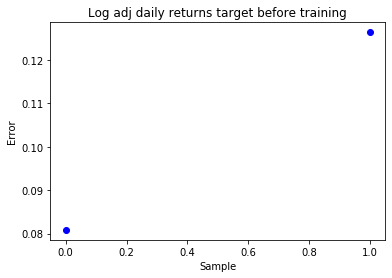

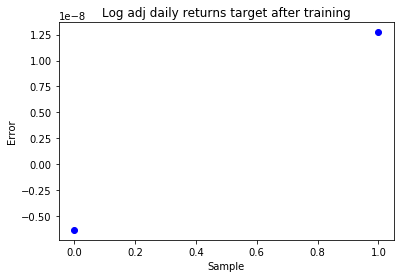


Plotting Each Sample's Time Series for Log Adjusted Daily Returns


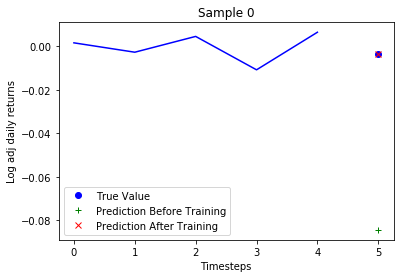

True Target Value: -0.0035051436379571754
Predicted Target Value Before Training: -0.08434920012950897
Predicted Target Value After Training: -0.0035051372833549976




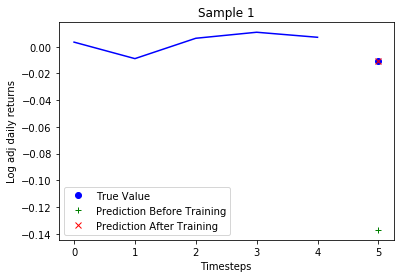

True Target Value: -0.010760221939794423
Predicted Target Value Before Training: -0.13711243867874146
Predicted Target Value After Training: -0.010760234668850899




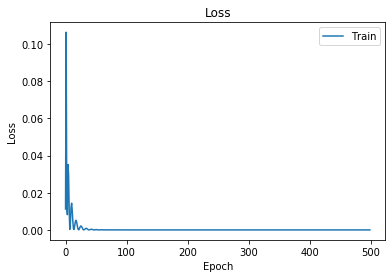

In [5]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)
overfit_small_sample(model_0, batch_size=2, epochs=500, X_small=X_small, y_small=y_small, verbose=0)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

#### Evaluating Model:

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f) 
     
# Defining Helper Functions 
def write_hparams(model_name, hparams, verbose=True):
    version_number = hparams['version']
    path = os.path.join('logs', 'models', model_name, '_'.join(['version', str(version_number)]))
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'hparams.pickle'), 'wb') as f:
        pickle.dump(hparams, f)
    if verbose:
        return print('Saved hyperparameters to file: {}'.format(path))
    else:
        return None

def build_compiled_model(build_model, model_name, hparams, metrics, run_number):
    hparam_version = hparams['version']
    loss = hparams['loss']
    optimizer = hparams['optimizer']
    model_parameters = hparams['model_parameters']
    model = build_model(**model_parameters)
    path_to_ckpt = os.path.join('logs', 'models', model_name, '_'.join(['version', str(hparam_version)]),
                               'runs', str(run_number), 'checkpoints')
    if os.path.exists(path_to_ckpt):
        latest = tf.train.latest_checkpoint(path_to_ckpt)
        model.load_weights(latest)
        print('Restored model from: {}'.format(latest))  
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
    
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Splitting train dataset into train and validation dataset.

In [4]:
train, val = split_dataset(train_dataset, train_size=0.75, random_state=seed)
X_train, y_train = train
X_val, y_val = val

print('Train set size: {}'.format(len(y_train['log_adj_daily_returns_target'])))
print('Validation set size: {}'.format(len(y_val['log_adj_daily_returns_target'])))
print('Test set size: {}'.format(len(test_dataset[1]['log_adj_daily_returns_target'])))

Train set size: 5557
Validation set size: 1853
Test set size: 2470


Building model.

In [5]:
# Defining and Saving Hyperparameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
model_params = {'lstm_layer_units': 256, 'vocab': vocab, 'doc_embedding_size': 200, 'output_bias_init': 0}
training_params = {'batch_size': 4, 'epochs': 1500}
model_version = 0
hyperparameters = {'model_parameters': model_params, 'training_parameters': training_params,
                   'loss': LOSS, 'optimizer': OPTIMIZER, 'version': model_version}
write_hparams('model_0', hyperparameters)

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Saved hyperparameters to file: logs/models/model_0/version_0


In [6]:
model = build_compiled_model(model_0, 'model_0', hyperparameters, metrics=metrics, run_number=run_number)

Restored model from: logs/models/model_0/version_0/runs/0/checkpoints/cp-100.ckpt


Training model.

In [ ]:
# Setting up callbacks
path_to_run = os.path.join('logs', 'models', 'model_0',
                            '_'.join(['version', str(hyperparameters['version'])]),
                            'runs', str(run_number))
path_to_ckpts = os.path.join(path_to_run, 'checkpoints')
if not os.path.exists(path_to_ckpts):
    os.makedirs(path_to_ckpts)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_to_ckpts, 'cp-{epoch}.ckpt'),
                                                 verbose=1, save_weights_only=True, period=10)
csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(path_to_run, 'history.log'), append=True)
callbacks = [cp_callback, csv_logger]

# Unpacking model training parameters
training_parameters = hyperparameters['training_parameters']

# Fetching last trained epoch if the model was reloaded
latest_ckpt = tf.train.latest_checkpoint(path_to_ckpts)
if latest_ckpt is not None:
    initial_epoch = re.findall(r'cp-(\d+)\.ckpt', latest_ckpt)[0]
    initial_epoch = int(initial_epoch) - 1
else:
    initial_epoch = 0

model_history = model.fit(X_train, y_train, **training_parameters,
                          initial_epoch=initial_epoch, callbacks=callbacks) # validation_data=(X_val, y_val)

Train on 5557 samples
Epoch 100/1500
5557/5557 [==============================] - 252s 45ms/sample - loss: 3.6727e-04
Epoch 101/1500
5557/5557 [==============================] - 268s 48ms/sample - loss: 3.6627e-04
Epoch 102/1500
5557/5557 [==============================] - 261s 47ms/sample - loss: 3.6860e-04
Epoch 103/1500
5557/5557 [==============================] - 268s 48ms/sample - loss: 3.6345e-04
Epoch 104/1500
5557/5557 [==============================] - 252s 45ms/sample - loss: 3.6142e-04
Epoch 105/1500
5557/5557 [==============================] - 242s 44ms/sample - loss: 3.5262e-04
Epoch 106/1500
5557/5557 [==============================] - 242s 44ms/sample - loss: 3.5099e-04
Epoch 107/1500
5557/5557 [==============================] - 240s 43ms/sample - loss: 3.4022e-04
Epoch 108/1500
5557/5557 [==============================] - 243s 44ms/sample - loss: 3.4392e-04
Epoch 109/1500
5556/5557 [============================>.] - ETA: 0s - loss: 3.4236e-04
Epoch 00109: saving model t

Evaluating model.

In [6]:
# Gathering Data
metrics_train = m.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_val = m.evaluate(X_val, y_val, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = m.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_val = m.predict(X_val, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_val = (m_preds_val[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_val = y_val['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


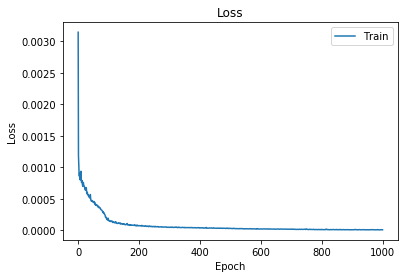

Loss on train dataset: 4.989523747099156e-06
Loss on validation dataset: 0.0013666351001578641

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.953


In [7]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(m_history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=m.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
#print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

In [13]:
print(m_preds_train[:, 0] - y_train['log_adj_daily_returns_target'])

[ 1.13168225e-03  1.37693441e-03 -2.94649532e-03 -1.56740499e-04
  4.42081054e-05 -3.45404711e-04  5.36118984e-03  9.30834364e-04
  5.31926171e-04  1.44887850e-03 -2.47901282e-04 -3.65341622e-04
  3.56802002e-04  7.11967797e-04 -1.27560368e-03  8.37871121e-04
 -1.34503763e-04  2.69293435e-03  9.56341079e-04 -1.14950259e-03
  2.05272523e-03 -1.90569279e-04  1.02836398e-03  1.51925673e-04
 -2.43840400e-03  3.17201876e-04  2.14913129e-04  4.67219653e-03
 -6.07072954e-04  1.27161215e-03 -1.61569804e-04 -2.18755926e-03
  5.60527626e-04 -2.99900742e-04 -2.93392637e-03 -1.29017887e-03
  1.24451332e-03 -2.86464556e-03  2.10590779e-03  3.58878227e-04
 -6.47977049e-04  5.22670123e-04  4.18972464e-05  2.25678377e-04
  1.22242156e-03 -2.12826496e-03  5.77997468e-04 -8.84464393e-04
  6.23337677e-04  1.60486713e-04 -2.85154816e-03  1.06104919e-03
  2.38532897e-04  7.96082155e-03  2.11155502e-03 -5.39792498e-03
  7.89332936e-04  1.43231601e-04  7.30393749e-03 -1.41602025e-03
 -1.88576120e-03 -1.42429

### Evaluating Selected Model

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = None

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions 
def write_hparams(model_name, hparams, verbose=True):
    version_number = hparams['version']
    path = os.path.join('logs', 'models', model_name, '_'.join(['version', str(version_number)]))
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'hparams.pickle'), 'wb') as f:
        pickle.dump(hparams, f)
    if verbose:
        return print('Saved hyperparameters to file: {}'.format(path))
    else:
        return None

def build_compiled_model(build_model, model_name, hparams, metrics, run_number):
    hparam_version = hparams['version']
    loss = hparams['loss']
    optimizer = hparams['optimizer']
    model_parameters = hparams['model_parameters']
    model = build_model(**model_parameters)
    path_to_ckpt = os.path.join('logs', 'models', model_name, '_'.join(['version', str(hparam_version)]),
                               'runs', str(run_number), 'checkpoints')
    if os.path.exists(path_to_ckpt):
        latest = tf.train.latest_checkpoint(path_to_ckpt)
        model.load_weights(latest)
        print('Restored model from: {}'.format(latest))  
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
    
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
X_train, y_train = train_dataset
X_test, y_test = test_dataset

In [3]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [4]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Building model.

In [5]:
# Defining and Saving Hyperparameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
model_params = {'lstm_layer_units': 256, 'vocab': vocab, 'doc_embedding_size': 200, 'output_bias_init': 0}
training_params = {'batch_size': 4, 'epochs': 50}
model_version = 'final'
hyperparameters = {'model_parameters': model_params, 'training_parameters': training_params,
                   'loss': LOSS, 'optimizer': OPTIMIZER, 'version': model_version}
write_hparams('model_selected', hyperparameters)

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Saved hyperparameters to file: logs/models/model_selected/version_final


In [6]:
model = build_compiled_model(model_0, 'model_selected', hyperparameters, metrics=metrics, run_number=run_number)

Training model on full train dataset.

In [ ]:
# Setting up callbacks
path_to_run = os.path.join('logs', 'models', 'model_selected',
                            '_'.join(['version', str(hyperparameters['version'])]),
                            'runs', str(run_number))
path_to_ckpts = os.path.join(path_to_run, 'checkpoints')
if not os.path.exists(path_to_ckpts):
    os.makedirs(path_to_ckpts)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_to_ckpts, 'cp-{epoch}.ckpt'),
                                                 verbose=1, save_weights_only=True, period=10)
csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(path_to_run, 'history.log'), append=True)
callbacks = [cp_callback, csv_logger]

# Unpacking model training parameters
training_parameters = hyperparameters['training_parameters']

# Fetching last trained epoch if the model was reloaded
latest_ckpt = tf.train.latest_checkpoint(path_to_ckpts)
if latest_ckpt is not None:
    initial_epoch = re.findall(r'cp-(\d+)\.ckpt', latest_ckpt)[0]
    initial_epoch = int(initial_epoch) - 1
else:
    initial_epoch = 0

model_history = model.fit(X_train, y_train, **training_parameters, validation_data=(X_test, y_test),
                          initial_epoch=initial_epoch, callbacks=callbacks)

Train on 7410 samples, validate on 2470 samples
Epoch 1/50
7410/7410 [==============================] - 402s 54ms/sample - loss: 0.0014 - val_loss: 7.1876e-04
Epoch 2/50
7410/7410 [==============================] - 405s 55ms/sample - loss: 8.5110e-04 - val_loss: 6.8347e-04
Epoch 3/50
7410/7410 [==============================] - 412s 56ms/sample - loss: 8.2944e-04 - val_loss: 6.7151e-04
Epoch 4/50
7410/7410 [==============================] - 407s 55ms/sample - loss: 8.0630e-04 - val_loss: 7.0192e-04
Epoch 5/50
7410/7410 [==============================] - 416s 56ms/sample - loss: 8.0736e-04 - val_loss: 6.6922e-04
Epoch 6/50
7410/7410 [==============================] - 411s 56ms/sample - loss: 7.9791e-04 - val_loss: 6.6630e-04
Epoch 7/50
5952/7410 [=======================>......] - ETA: 1:08 - loss: 7.4832e-04

Evaluating model on test dataset.

In [6]:
# Gathering Data
metrics_train = m.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_test = m.evaluate(X_test, y_test, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = m.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_test = m.predict(X_test, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_test = (m_preds_test[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_test = y_test['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_test = np.mean(np.equal(m_preds_up_test, labels_up_test))

Learning Curves for Metrics:


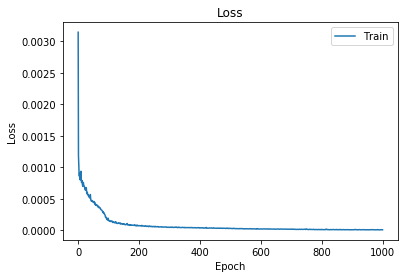

Loss on train dataset: 4.989523747099156e-06
Loss on validation dataset: 0.0013666351001578641

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.953


In [7]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(m_history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=m.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

## Training and Saving Model for Deployment

Saving model for deployment.

In [5]:
m.save(os.path.join(path_to_models, 'model_0'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /media/Data/Programs/FinTech/models/model_0/assets
